In [1]:
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time

import pandas as pd 

from scipy import optimize
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#### parallelization 
options = qt.Options(num_cpus=6)



In [2]:

### Setup matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{bbm} \usepackage{lmodern} \usepackage{amsmath} \usepackage{amstext}  \usepackage{amsfonts}",
    "font.family": "serif",
    "font.serif": "STIX",
    "mathtext.fontset": "stix",
    "font.size": 10,
    "font.weight": 'bold',
    
    "savefig.dpi" : 300,
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.5,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.5,     # distance to the minor tick label in points
    #
    "xtick.major.size": 3.0, 
    "ytick.major.size": 3.0,
    
    "xtick.minor.size": 3.0, 
    "ytick.minor.size": 3.0,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True
})

##############
####### 

In [3]:
def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ls, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = sp.linalg.eig(np.conjugate(Ls).T)
    elif side == "right":
        e_values, e_vectors = sp.linalg.eig(Ls)
    else: raise ValueError('You have to choose or left or right')
         
    # Get the maximum eigenvalue and its corresponding index
    dominant_e, idx = Get_maximum(e_values)

    # Get dimension
    d = int(np.sqrt(np.shape(Ls)[0]))
    
    # reshaping the result
    e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
    # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
    
    #return e_values[idx], e_mat/np.trace(e_mat)
    return e_values[idx], e_mat

###############
####### Coding 
###############

In [4]:
def entropy_prod_current(t, jump, args):
    ### if hot bath

    if jump == 0:  # |0><1| 
        return -args["beta_h"](t, args)*(args["omega"] - args["Omega"])
    elif jump == 1:# |1><0|
        return args["beta_h"](t, args)*(args["omega"] - args["Omega"])
    elif jump == 2:# |0><2|
        return -args["beta_h"](t, args)*(args["omega"] + args["Omega"])
    elif jump == 3:# |2><0|
        return args["beta_h"](t, args)*(args["omega"] + args["Omega"])
    elif jump == 4:# |1><3|
        return -args["beta_h"](t, args)*(args["omega"] + args["Omega"])
    elif jump == 5:# |3><1|
        return args["beta_h"](t, args)*(args["omega"] + args["Omega"])
    elif jump == 6:# |2><3|
        return -args["beta_h"](t, args)*(args["omega"] - args["Omega"])
    elif jump == 7:# |3><2|
        return args["beta_h"](t, args)*(args["omega"] - args["Omega"])
    
    ### if cold bath

    elif jump == 8:# |0><1|
        return -args["beta0_c"]*(args["omega"] - args["Omega"])
    elif jump == 9:# |1><0|
        return args["beta0_c"]*(args["omega"]  - args["Omega"])
    elif jump == 10:# |0><2|
        return -args["beta0_c"]*(args["omega"] + args["Omega"])
    elif jump == 11:# |2><0|
        return args["beta0_c"]*(args["omega"] + args["Omega"])
    elif jump == 12:# |1><3|
        return -args["beta0_c"]*(args["omega"] + args["Omega"])
    elif jump == 13:# |3><1|
        return args["beta0_c"]*(args["omega"] + args["Omega"])
    elif jump == 14:# |2><3|
        return -args["beta0_c"]*(args["omega"] - args["Omega"])
    elif jump == 15:# |3><2|
        return args["beta0_c"]*(args["omega"] - args["Omega"])
    
    
    
def organize_jumps(col_times, col_which, Nboxes, args):
    # Set dt
    dt = args["tau"]/(Nboxes)
    # Initialize N empty arrays
    times = [[] for _ in range(Nboxes)]
    jumps = [[] for _ in range(Nboxes)]
    entropy_current = [0 for _ in range(Nboxes)]
    
    # Organize time instants into arrays
    for i, t in enumerate(col_times):
        n = int(t // dt)
        times[n].append(t)
        jumps[n].append(col_which[i])
        entropy_current[n] += entropy_prod_current(t, col_which[i], args)
    return times, jumps, entropy_current

In [5]:
def Tilted_lindbladian(t, H0, cops, args):

    
    omega = args["omega"]
    Omega = args["Omega"]
    s = args["s_func"](t, args)
    bh = args["beta_h"](t, args)
    bc = args["beta0_c"]
    
    
    Ide = qt.tensor(qt.qeye(2), qt.qeye(2))

    Flat_H0  = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()
    
    
    J_01_h, J_10_h, J_02_h, J_20_h, J_13_h, J_31_h, J_23_h, J_32_h = cops[0:8]
    J_01_c, J_10_c, J_02_c, J_20_c, J_13_c, J_31_c, J_23_c, J_32_c = cops[8:]
    
    
    ####### Non-hermitian evolution 
    ## hot bath
    Flat_J_01_h = -(1.0/2.0)*(qt.tensor(Ide, J_01_h.dag()*J_01_h) + qt.tensor((J_01_h.dag()*J_01_h).trans(), Ide)).full()
    Flat_J_02_h = -(1.0/2.0)*(qt.tensor(Ide, J_02_h.dag()*J_02_h) + qt.tensor((J_02_h.dag()*J_02_h).trans(), Ide)).full()
    Flat_J_13_h = -(1.0/2.0)*(qt.tensor(Ide, J_13_h.dag()*J_13_h) + qt.tensor((J_13_h.dag()*J_13_h).trans(), Ide)).full()
    Flat_J_23_h = -(1.0/2.0)*(qt.tensor(Ide, J_23_h.dag()*J_23_h) + qt.tensor((J_23_h.dag()*J_23_h).trans(), Ide)).full()

    Flat_J_10_h = -(1.0/2.0)*(qt.tensor(Ide, J_10_h.dag()*J_10_h) + qt.tensor((J_10_h.dag()*J_10_h).trans(), Ide)).full()
    Flat_J_20_h = -(1.0/2.0)*(qt.tensor(Ide, J_20_h.dag()*J_20_h) + qt.tensor((J_20_h.dag()*J_20_h).trans(), Ide)).full()
    Flat_J_31_h = -(1.0/2.0)*(qt.tensor(Ide, J_31_h.dag()*J_31_h) + qt.tensor((J_31_h.dag()*J_31_h).trans(), Ide)).full()
    Flat_J_32_h = -(1.0/2.0)*(qt.tensor(Ide, J_32_h.dag()*J_32_h) + qt.tensor((J_32_h.dag()*J_32_h).trans(), Ide)).full()

    ## cold bath
    Flat_J_01_c = -(1.0/2.0)*(qt.tensor(Ide, J_01_c.dag()*J_01_c) + qt.tensor((J_01_c.dag()*J_01_c).trans(), Ide)).full()
    Flat_J_02_c = -(1.0/2.0)*(qt.tensor(Ide, J_02_c.dag()*J_02_c) + qt.tensor((J_02_c.dag()*J_02_c).trans(), Ide)).full()
    Flat_J_13_c = -(1.0/2.0)*(qt.tensor(Ide, J_13_c.dag()*J_13_c) + qt.tensor((J_13_c.dag()*J_13_c).trans(), Ide)).full()
    Flat_J_23_c = -(1.0/2.0)*(qt.tensor(Ide, J_23_c.dag()*J_23_c) + qt.tensor((J_23_c.dag()*J_23_c).trans(), Ide)).full()

    Flat_J_10_c = -(1.0/2.0)*(qt.tensor(Ide, J_10_c.dag()*J_10_c) + qt.tensor((J_10_c.dag()*J_10_c).trans(), Ide)).full()
    Flat_J_20_c = -(1.0/2.0)*(qt.tensor(Ide, J_20_c.dag()*J_20_c) + qt.tensor((J_20_c.dag()*J_20_c).trans(), Ide)).full()
    Flat_J_31_c = -(1.0/2.0)*(qt.tensor(Ide, J_31_c.dag()*J_31_c) + qt.tensor((J_31_c.dag()*J_31_c).trans(), Ide)).full()
    Flat_J_32_c = -(1.0/2.0)*(qt.tensor(Ide, J_32_c.dag()*J_32_c) + qt.tensor((J_32_c.dag()*J_32_c).trans(), Ide)).full()

    Flat_Inc_h = (Flat_J_01_h + Flat_J_02_h + Flat_J_13_h + Flat_J_23_h
                + Flat_J_10_h + Flat_J_20_h + Flat_J_31_h + Flat_J_32_h)

    Flat_Inc_c = (Flat_J_01_c + Flat_J_02_c + Flat_J_13_c + Flat_J_23_c
                + Flat_J_10_c + Flat_J_20_c + Flat_J_31_c + Flat_J_32_c)

    ####### Jumps 
    # hot bath
    Flat_jump_J_01_h = (qt.tensor(J_01_h.conj(),J_01_h)).full()
    Flat_jump_J_02_h = (qt.tensor(J_02_h.conj(),J_02_h)).full()
    Flat_jump_J_13_h = (qt.tensor(J_13_h.conj(),J_13_h)).full()
    Flat_jump_J_23_h = (qt.tensor(J_23_h.conj(),J_23_h)).full()

    Flat_jump_J_10_h = (qt.tensor(J_10_h.conj(),J_10_h)).full()
    Flat_jump_J_20_h = (qt.tensor(J_20_h.conj(),J_20_h)).full()
    Flat_jump_J_31_h = (qt.tensor(J_31_h.conj(),J_31_h)).full()
    Flat_jump_J_32_h = (qt.tensor(J_32_h.conj(),J_32_h)).full()
    
    #cold bath
    Flat_jump_J_01_c = (qt.tensor(J_01_c.conj(),J_01_c)).full()
    Flat_jump_J_02_c = (qt.tensor(J_02_c.conj(),J_02_c)).full()
    Flat_jump_J_13_c = (qt.tensor(J_13_c.conj(),J_13_c)).full()
    Flat_jump_J_23_c = (qt.tensor(J_23_c.conj(),J_23_c)).full()

    Flat_jump_J_10_c = (qt.tensor(J_10_c.conj(),J_10_c)).full()
    Flat_jump_J_20_c = (qt.tensor(J_20_c.conj(),J_20_c)).full()
    Flat_jump_J_31_c = (qt.tensor(J_31_c.conj(),J_31_c)).full()
    Flat_jump_J_32_c = (qt.tensor(J_32_c.conj(),J_32_c)).full()

    Flat_Jump_h = (  np.exp(+s*(omega-Omega)*bh)*Flat_jump_J_01_h 
                   + np.exp(+s*(omega+Omega)*bh)*Flat_jump_J_02_h 
                   + np.exp(+s*(omega+Omega)*bh)*Flat_jump_J_13_h 
                   + np.exp(+s*(omega-Omega)*bh)*Flat_jump_J_23_h

                   + np.exp(-s*(omega-Omega)*bh)*Flat_jump_J_10_h 
                   + np.exp(-s*(omega+Omega)*bh)*Flat_jump_J_20_h 
                   + np.exp(-s*(omega+Omega)*bh)*Flat_jump_J_31_h 
                   + np.exp(-s*(omega-Omega)*bh)*Flat_jump_J_32_h)

    Flat_Jump_c = (  np.exp(+s*(omega-Omega)*bc)*Flat_jump_J_01_c 
                   + np.exp(+s*(omega+Omega)*bc)*Flat_jump_J_02_c 
                   + np.exp(+s*(omega+Omega)*bc)*Flat_jump_J_13_c 
                   + np.exp(+s*(omega-Omega)*bc)*Flat_jump_J_23_c

                   + np.exp(-s*(omega-Omega)*bc)*Flat_jump_J_10_c 
                   + np.exp(-s*(omega+Omega)*bc)*Flat_jump_J_20_c 
                   + np.exp(-s*(omega+Omega)*bc)*Flat_jump_J_31_c 
                   + np.exp(-s*(omega-Omega)*bc)*Flat_jump_J_32_c)

    Lst = Flat_H0 + Flat_Inc_h + Flat_Jump_h + Flat_Inc_c + Flat_Jump_c     

    return Lst.astype(complex)




In [6]:
########## Rates 

#####
##### hot bath
#####

def J_01_h_t(t, args): 
    return J_01*(np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))) ) 
    
def J_10_h_t(t, args):
    return J_10*(np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1)))) 
    
def J_02_h_t(t, args):
    return J_02*(np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_20_h_t(t, args):
    return J_20*(np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1))))     
    
def J_13_h_t(t, args):
    return J_13*(np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1))))
    
def J_31_h_t(t, args):
    return J_31*(np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_23_h_t(t, args):
    return J_23*(np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))))
       
def J_32_h_t(t, args):
    return J_32*(np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))))
  
#####
##### cold bath
#####

def J_01_c_t(t, args): 
    return J_01*(np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))) ) 

def J_10_c_t(t, args):
    return J_10*(np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1)))) 
    
def J_02_c_t(t, args):
    return J_02*(np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_20_c_t(t, args):
    return J_20*(np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1))))     
    
def J_13_c_t(t, args):
    return J_13*(np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1))))
    
def J_31_c_t(t, args):
    return J_31*(np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_23_c_t(t, args):
    return J_23*(np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))))
       
def J_32_c_t(t, args):
    return J_32*(np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))))
    


In [103]:
def get_List_Doob_system(H0, dt, args):
    ####
    #### Get a list of the auxiliary system in each time for the trajectories  
    ####

    tilted_H = []
    tilted_cops = []
    tau = args["tau"]
    tlist = np.arange(0, tau, dt/2)
    
    Nsteps = int(tau/(tlist[1]-tlist[0]))
    
    data = {}
    for i, t in enumerate(tlist): 
    
        t0 = time.time()
        
        cops = [J_01_h_t(t, args), J_10_h_t(t, args), 
                J_02_h_t(t, args), J_20_h_t(t, args), 
                J_13_h_t(t, args), J_31_h_t(t, args),
                J_23_h_t(t, args), J_32_h_t(t, args),
                J_01_c_t(t, args), J_10_c_t(t, args), 
                J_02_c_t(t, args), J_20_c_t(t, args), 
                J_13_c_t(t, args), J_31_c_t(t, args),
                J_23_c_t(t, args), J_32_c_t(t, args)]
    
        
        #### Tilted Lindbladian 
    
        #Ls = Tilted_lindbladian(t, H0, cops, args)
    
        #lambda0, l0 = Numeric_diagonalization(Ls, side="right")
    
        #### Non-hermitian term of the deterministic evolution
        
        Hcops = qt.zero_ket(4, [[2, 2], [2, 2]]) * qt.zero_ket(4, [[2, 2], [2, 2]]).dag()
        for c in cops:
            Hcops += c.dag() * c
        ####
        l0sqr = qt.Qobj(np.identity(4), dims=[[2, 2], [2, 2]])
        
        
        Haux = l0sqr * (H0 - 0.5j*Hcops) * l0sqr.inv()
        
        cops_aux = [l0sqr*c*l0sqr.inv() for c in cops]
        
        #data.update({i:[Haux, cops_aux]})
        data.update({i:[H0, cops]})
        
        if i % 100 == 0:
            print(pd.DataFrame(l0sqr.full()))
            print("Doob rotation time: {}   -   Rotation {} of {} \n".format(time.time()-t0, i, Nsteps))
        
    data.update({"time":tlist})
    return data 
    

In [111]:
def OneTrajectory(psi, Hdata):

    tlist = Hdata["time"]
    Nsteps = len(tlist)
    
    dt = tlist[2] - tlist[0]
    
    R = np.random.rand() 
    
    jumps = []
    times = []
    for i, t in enumerate(tlist): 
        
        if i % 2 == 0 or i < Nsteps-1: 

            Hauxt = Hdata[i][0]
            Hauxt2 = Hdata[i+1][0]
        
            k1 = -1.0j*Hauxt  * psi
            k2 = -1.0j*Hauxt2 * (psi + k1 * dt / 2)
            k3 = -1.0j*Hauxt2 * (psi + k2 * dt / 2)
            k4 = -1.0j*Hauxt  * (psi + k3 * dt)
    
            psi = psi + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        
            print(psi.norm())
            if np.isclose(psi.norm(),R, 10e-1):
                prob = [(c * psi).norm() for c in Hdata[i][1]] 
                prob = np.array(prob)/np.sum(prob)

                jump = np.random.choice(16, p=prob)
                
                psi = Hdata[i][1][jump] * psi
                psi = psi/np.sqrt(psi.norm())
                
                jumps.append(jump)
                times.append(t)
                R = np.random.rand() 
                
            else:continue 
        else: continue 
            
    return jumps, times

In [112]:
def get_trajectories(psi, Hdata, ntraj):
    jumps_list, times_list = [], []
    
    for traj in range(ntraj):
        t0 = time.time()
        jumps, times = OneTrajectory(psi, Hlist)
        jumps_list.append(jumps)
        times_list.append(times)
        if traj % (ntraj//10)== 0: 
            print("Execution time: {}   -   Run {} of {}".format(time.time()-t0, traj, ntraj))
    return jumps_list, times_list

In [113]:
# Define the states
ket00 = qt.tensor(qt.basis(2,1), qt.basis(2,1))
ket01 = qt.tensor(qt.basis(2,1), qt.basis(2,0))
ket10 = qt.tensor(qt.basis(2,0), qt.basis(2,1))
ket11 = qt.tensor(qt.basis(2,0), qt.basis(2,0))

sigmam_h = qt.tensor(qt.sigmam(), qt.qeye(2))
sigmam_c = qt.tensor(qt.qeye(2), qt.sigmam())
sigmap_h = qt.tensor(qt.sigmap(), qt.qeye(2))
sigmap_c = qt.tensor(qt.qeye(2), qt.sigmap())

sigmax_h = qt.tensor(qt.sigmax(), qt.qeye(2))
sigmax_c = qt.tensor(qt.qeye(2), qt.sigmax())

sigmaz_h = qt.tensor(qt.sigmaz(), qt.qeye(2))
sigmaz_c = qt.tensor(qt.qeye(2), qt.sigmaz())

eps0 = ket00
eps1 = np.sqrt(1/2)*(ket01 - ket10)
eps2 = np.sqrt(1/2)*(ket01 + ket10)
eps3 = ket11
    
##### Transitions 
    
J_01 = eps0 * eps1.dag()
    
J_10 = eps1 * eps0.dag() 
        
J_02 = eps0 * eps2.dag()
    
J_20 = eps2 * eps0.dag()
    
J_13 = eps1 * eps3.dag()

J_31 = eps3 * eps1.dag()

J_23 = eps2 * eps3.dag()
    
J_32 = eps3 * eps2.dag()

In [114]:
####### Parameters 

omega = 1.0
alpha_h = 1.0
alpha_c = 1.0
beta0_h = 1.0/(2.0) # T = 2
beta0_c = 1.0/(1.0) # T = 1
Omega = 0.5
g = 1.0

def s_func(t, args):
    #return np.tanh(2*t/args["tau"] - 1)
    return 0 

def beta_h(t, args):
    return 1/(1/args["beta0_h"] + np.sin(t*np.pi/args["tau"])**2)


############# Total dynamics time


tau = 500
#Nsteps = 1000


############# Argumets dict 

args  = {"omega":omega,
         "Omega":Omega,
         "g":g,
         "alpha_h":alpha_h,
         "alpha_c":alpha_c,
         "beta_h":beta_h,
         "beta0_h":beta0_h,
         "beta0_c":beta0_c,
         "s_func": s_func,
         "tau":tau}

In [115]:
####### Hamiltonian    
    
H0 = (Omega*( sigmam_h*sigmap_c + sigmap_h*sigmam_c) 
        + g*(sigmax_c + sigmax_h) 
        + (omega/2)*(sigmaz_c + sigmaz_h))

####### Jump operators 

In [109]:
#### Get the list of the auxliariy system at each time

dt = 0.1

Hlist = get_List_Doob_system(H0, dt=dt, args=args)

print("We have {} intervals \n".format(int(tau/dt)))

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.027901887893676758   -   Rotation 0 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.005808115005493164   -   Rotation 100 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.005224943161010742   -   Rotation 200 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.005690813064575195   -   Rotation 3000 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.005620002746582031   -   Rotation 3100 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.0057489871978759766   -   Rotation 3200 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.0057239532470703125   -   Rotation 6000 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.008805990219116211   -   Rotation 6100 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.008468151092529297   -   Rotation 6200 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.00615692138671875   -   Rotation 9100 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.005845069885253906   -   Rotation 9200 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j
3  0.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j
Doob rotation time: 0.005664825439453125   -   Rotation 9300 of 10000 

          0         1         2         3
0  1.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j
1  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j
2  0.0+0.0j  0.0+0.0j  1.0+0.

In [116]:
ntraj = 10

psi0 = qt.tensor(qt.basis(2,1), qt.basis(2,0))
jumps, times = get_trajectories(psi0, Hlist, ntraj)

0.9999995577372949
0.9999991154755569
0.9999986732147855
0.9999982309549812
0.9999977886961435
0.9999973464382728
0.9999969041813686
0.9999964619254315
0.999996019670461
0.9999955774164575
0.9999951351634209
0.9999946929113508
0.9999942506602477
0.9999938084101114
0.9999933661609419
0.9999929239127391
0.9999924816655033
0.9999920394192342
0.9999915971739319
0.9999911549295964
0.9999907126862276
0.9999902704438258
0.9999898282023906
0.9999893859619221
0.9999889437224205
0.9999885014838857
0.9999880592463176
0.9999876170097166
0.999987174774082
0.9999867325394144
0.9999862903057135
0.9999858480729792
0.9999854058412119
0.9999849636104112
0.9999845213805775
0.9999840791517105
0.99998363692381
0.9999831946968765
0.9999827524709095
0.9999823102459096
0.9999818680218762
0.9999814257988097
0.9999809835767097
0.9999805413555767
0.9999800991354103
0.9999796569162107
0.9999792146979779
0.9999787724807118
0.9999783302644123
0.9999778880490797
0.9999774458347137
0.9999770036213144
0.99997656140888

0.999469097498206
0.9994686563961576
0.9994682152950733
0.9994677741949535
0.9994673330957982
0.9994668919976071
0.9994664509003803
0.9994660098041179
0.9994655687088201
0.9994651276144866
0.9994646865211172
0.9994642454287124
0.9994638043372718
0.9994633632467956
0.9994629221572838
0.9994624810687364
0.9994620399811532
0.9994615988945346
0.9994611578088801
0.9994607167241901
0.9994602756404642
0.9994598345577029
0.999459393475906
0.9994589523950732
0.9994585113152047
0.9994580702363008
0.999457629158361
0.9994571880813858
0.9994567470053746
0.9994563059303279
0.9994558648562454
0.9994554237831272
0.9994549827109734
0.9994545416397839
0.9994541005695587
0.9994536595002979
0.9994532184320013
0.999452777364669
0.9994523362983011
0.9994518952328973
0.999451454168458
0.999451013104983
0.9994505720424722
0.9994501309809258
0.9994496899203434
0.9994492488607257
0.999448807802072
0.9994483667443828
0.9994479256876577
0.9994474846318971
0.9994470435771006
0.9994466025232682
0.9994461614704004


0.9992654110159604
0.9992649703592371
0.9992645297034771
0.9992640890486804
0.9992636483948474
0.9992632077419776
0.9992627670900712
0.9992623264391285
0.9992618857891492
0.9992614451401332
0.9992610044920807
0.9992605638449914
0.9992601231988657
0.9992596825537032
0.9992592419095044
0.9992588012662686
0.9992583606239966
0.9992579199826879
0.9992574793423424
0.9992570387029607
0.9992565980645419
0.999256157427087
0.9992557167905951
0.9992552761550668
0.9992548355205016
0.9992543948869003
0.9992539542542621
0.9992535136225873
0.9992530729918758
0.9992526323621279
0.9992521917333432
0.9992517511055219
0.999251310478664
0.9992508698527695
0.9992504292278384
0.9992499886038705
0.9992495479808661
0.999249107358825
0.9992486667377473
0.9992482261176331
0.9992477854984819
0.9992473448802942
0.9992469042630701
0.9992464636468091
0.9992460230315116
0.9992455824171774
0.9992451418038063
0.999244701191399
0.9992442605799546
0.9992438199694738
0.9992433793599562
0.9992429387514019
0.99924249814381

0.9989043958282037
0.9989039559608133
0.9989035160943849
0.998903076228918
0.998902636364413
0.9989021965008699
0.9989017566382883
0.9989013167766686
0.9989008769160105
0.9989004370563144
0.9988999971975798
0.998899557339807
0.9988991174829962
0.9988986776271469
0.9988982377722594
0.9988977979183334
0.9988973580653695
0.998896918213367
0.9988964783623266
0.9988960385122477
0.9988955986631306
0.9988951588149753
0.9988947189677817
0.9988942791215496
0.9988938392762793
0.9988933994319709
0.9988929595886242
0.9988925197462392
0.9988920799048158
0.9988916400643543
0.9988912002248543
0.9988907603863161
0.9988903205487395
0.9988898807121247
0.9988894408764716
0.9988890010417801
0.9988885612080505
0.9988881213752824
0.9988876815434762
0.9988872417126315
0.9988868018827485
0.9988863620538271
0.9988859222258677
0.9988854823988698
0.9988850425728335
0.998884602747759
0.9988841629236462
0.998883723100495
0.9988832832783054
0.9988828434570776
0.9988824036368115
0.998881963817507
0.9988815239991641


0.9986366945687765
0.9986362552867248
0.9986358160056339
0.9986353767255033
0.9986349374463336
0.9986344981681242
0.9986340588908754
0.998633619614587
0.998633180339259
0.9986327410648916
0.998632301791485
0.9986318625190386
0.9986314232475527
0.9986309839770274
0.9986305447074627
0.9986301054388583
0.9986296661712145
0.9986292269045312
0.9986287876388084
0.9986283483740461
0.9986279091102442
0.9986274698474028
0.998627030585522
0.9986265913246016
0.9986261520646418
0.9986257128056423
0.9986252735476034
0.998624834290525
0.9986243950344068
0.9986239557792495
0.9986235165250525
0.9986230772718159
0.9986226380195399
0.9986221987682241
0.998621759517869
0.9986213202684743
0.99862088102004
0.9986204417725661
0.9986200025260528
0.9986195632805
0.9986191240359075
0.9986186847922757
0.998618245549604
0.998617806307893
0.9986173670671423
0.998616927827352
0.9986164885885224
0.998616049350653
0.998615610113744
0.9986151708777956
0.9986147316428076
0.9986142924087797
0.9986138531757125
0.9986134

0.9982987316136279
0.9982982930705809
0.998297854528493
0.9982974159873639
0.9982969774471938
0.9982965389079826
0.9982961003697305
0.9982956618324372
0.9982952232961029
0.9982947847607275
0.9982943462263111
0.9982939076928539
0.9982934691603552
0.9982930306288156
0.9982925920982351
0.9982921535686133
0.9982917150399505
0.9982912765122467
0.9982908379855018
0.9982903994597159
0.9982899609348886
0.9982895224110208
0.9982890838881114
0.9982886453661611
0.9982882068451697
0.9982877683251373
0.9982873298060638
0.9982868912879491
0.9982864527707935
0.9982860142545967
0.9982855757393587
0.9982851372250797
0.9982846987117597
0.9982842601993985
0.9982838216879962
0.9982833831775529
0.9982829446680684
0.9982825061595426
0.998282067651976
0.9982816291453682
0.9982811906397193
0.9982807521350291
0.9982803136312981
0.9982798751285257
0.9982794366267124
0.9982789981258579
0.998278559625962
0.9982781211270253
0.9982776826290475
0.9982772441320285
0.9982768056359682
0.9982763671408669
0.9982759286467

0.997963964080665
0.9979635262696746
0.9979630884596417
0.9979626506505659
0.9979622128424476
0.9979617750352868
0.9979613372290834
0.9979608994238373
0.9979604616195487
0.9979600238162175
0.9979595860138436
0.9979591482124271
0.997958710411968
0.9979582726124663
0.997957834813922
0.9979573970163351
0.9979569592197056
0.9979565214240335
0.9979560836293188
0.9979556458355615
0.9979552080427615
0.9979547702509188
0.9979543324600336
0.9979538946701059
0.9979534568811353
0.9979530190931222
0.9979525813060665
0.997952143519968
0.9979517057348269
0.9979512679506435
0.9979508301674171
0.9979503923851479
0.9979499546038363
0.9979495168234822
0.9979490790440851
0.9979486412656454
0.9979482034881634
0.9979477657116383
0.9979473279360708
0.9979468901614605
0.9979464523878079
0.9979460146151121
0.9979455768433738
0.9979451390725932
0.9979447013027696
0.9979442635339033
0.9979438257659945
0.9979433879990429
0.9979429502330487
0.9979425124680117
0.9979420747039321
0.9979416369408097
0.99794119917864

0.9977604852220879
0.997760047856076
0.9977596104910205
0.9977591731269214
0.9977587357637788
0.9977582984015928
0.9977578610403631
0.9977574236800901
0.9977569863207734
0.9977565489624132
0.9977561116050095
0.997755674248562
0.9977552368930712
0.9977547995385367
0.997754362184959
0.9977539248323374
0.9977534874806722
0.9977530501299635
0.9977526127802113
0.9977521754314154
0.9977517380835762
0.9977513007366933
0.9977508633907668
0.9977504260457967
0.997749988701783
0.9977495513587259
0.9977491140166251
0.9977486766754807
0.9977482393352927
0.9977478019960614
0.9977473646577861
0.9977469273204674
0.997746489984105
0.9977460526486992
0.9977456153142497
0.9977451779807567
0.9977447406482199
0.9977443033166398
0.9977438659860158
0.9977434286563485
0.9977429913276373
0.9977425539998827
0.9977421166730842
0.9977416793472424
0.9977412420223569
0.9977408046984277
0.9977403673754551
0.9977399300534388
0.9977394927323786
0.9977390554122751
0.9977386180931277
0.9977381807749369
0.997737743457702

0.9974056587737332
0.9974052221837088
0.9974047855946395
0.9974043490065249
0.9974039124193652
0.9974034758331601
0.9974030392479101
0.9974026026636148
0.9974021660802743
0.9974017294978885
0.9974012929164576
0.9974008563359817
0.9974004197564604
0.997399983177894
0.9973995466002825
0.9973991100236257
0.9973986734479237
0.9973982368731764
0.9973978002993841
0.9973973637265463
0.9973969271546634
0.9973964905837356
0.9973960540137624
0.9973956174447438
0.9973951808766801
0.9973947443095712
0.9973943077434171
0.9973938711782178
0.997393434613973
0.9973929980506834
0.9973925614883483
0.9973921249269682
0.9973916883665425
0.9973912518070718
0.9973908152485559
0.9973903786909947
0.9973899421343883
0.9973895055787364
0.9973890690240395
0.9973886324702974
0.99738819591751
0.9973877593656773
0.9973873228147994
0.9973868862648763
0.9973864497159076
0.9973860131678939
0.997385576620835
0.9973851400747308
0.9973847035295812
0.9973842669853865
0.9973838304421465
0.9973833938998611
0.997382957358530

0.9969307774582318
0.9969303419068168
0.9969299063563544
0.9969294708068444
0.9969290352582872
0.9969285997106826
0.9969281641640306
0.9969277286183313
0.9969272930735845
0.9969268575297903
0.9969264219869488
0.9969259864450599
0.9969255509041235
0.9969251153641396
0.9969246798251087
0.9969242442870301
0.9969238087499043
0.9969233732137308
0.9969229376785101
0.9969225021442419
0.9969220666109263
0.9969216310785634
0.996921195547153
0.9969207600166952
0.9969203244871899
0.9969198889586374
0.9969194534310372
0.9969190179043899
0.9969185823786949
0.9969181468539525
0.9969177113301627
0.9969172758073256
0.9969168402854409
0.9969164047645087
0.9969159692445292
0.9969155337255022
0.9969150982074279
0.9969146626903057
0.9969142271741367
0.9969137916589199
0.9969133561446557
0.9969129206313441
0.9969124851189849
0.9969120496075783
0.9969116140971246
0.9969111785876229
0.9969107430790739
0.9969103075714777
0.9969098720648335
0.9969094365591423
0.9969090010544035
0.9969085655506172
0.99690813004

0.996710510111128
0.9967100750414837
0.996709639972791
0.99670920490505
0.9967087698382607
0.9967083347724229
0.9967078997075366
0.9967074646436022
0.996707029580619
0.9967065945185877
0.9967061594575077
0.9967057243973796
0.9967052893382029
0.9967048542799778
0.9967044192227044
0.9967039841663824
0.996703549111012
0.9967031140565933
0.9967026790031261
0.9967022439506106
0.9967018088990465
0.996701373848434
0.996700938798773
0.9967005037500637
0.9967000687023058
0.9966996336554997
0.996699198609645
0.9966987635647417
0.9966983285207901
0.9966978934777901
0.9966974584357416
0.9966970233946446
0.9966965883544993
0.9966961533153055
0.996695718277063
0.9966952832397725
0.9966948482034331
0.9966944131680454
0.9966939781336094
0.9966935431001246
0.9966931080675916
0.9966926730360101
0.99669223800538
0.9966918029757014
0.9966913679469744
0.9966909329191989
0.9966904978923751
0.9966900628665025
0.9966896278415815
0.996689192817612
0.9966887577945942
0.9966883227725276
0.9966878877514127
0.9966

0.9964548533184006
0.9964544188079517
0.9964539842984537
0.9964535497899059
0.9964531152823084
0.9964526807756614
0.9964522462699651
0.9964518117652188
0.996451377261423
0.9964509427585777
0.996450508256683
0.9964500737557381
0.996449639255744
0.9964492047567004
0.9964487702586071
0.9964483357614642
0.9964479012652717
0.9964474667700294
0.9964470322757376
0.9964465977823963
0.9964461632900052
0.9964457287985646
0.9964452943080742
0.9964448598185345
0.9964444253299449
0.9964439908423057
0.996443556355617
0.9964431218698788
0.9964426873850908
0.9964422529012531
0.9964418184183659
0.9964413839364287
0.9964409494554421
0.996440514975406
0.99644008049632
0.9964396460181845
0.9964392115409993
0.9964387770647646
0.9964383425894802
0.996437908115146
0.996437473641762
0.9964370391693287
0.9964366046978457
0.9964361702273129
0.9964357357577305
0.9964353012890983
0.9964348668214166
0.9964344323546852
0.9964339978889041
0.9964335634240733
0.9964331289601928
0.9964326944972627
0.9964322600352828
0.

0.996220789936505
0.99622035593804
0.9962199219405244
0.9962194879439583
0.9962190539483413
0.9962186199536739
0.9962181859599556
0.9962177519671865
0.9962173179753671
0.9962168839844968
0.9962164499945759
0.996216016005604
0.996215582017582
0.9962151480305088
0.9962147140443851
0.996214280059211
0.9962138460749856
0.9962134120917098
0.9962129781093834
0.9962125441280061
0.9962121101475784
0.9962116761680996
0.9962112421895704
0.9962108082119902
0.9962103742353595
0.9962099402596781
0.996209506284946
0.9962090723111631
0.9962086383383294
0.9962082043664452
0.9962077703955102
0.9962073364255244
0.996206902456488
0.9962064684884007
0.9962060345212628
0.9962056005550741
0.9962051665898346
0.9962047326255445
0.9962042986622037
0.9962038646998121
0.9962034307383695
0.9962029967778764
0.9962025628183325
0.996202128859738
0.9962016949020926
0.9962012609453964
0.9962008269896495
0.996200393034852
0.9961999590810036
0.9961995251281044
0.9961990911761543
0.9961986572251538
0.9961982232751023
0.9

0.9960104120662276
0.996009978527953
0.9960095449906269
0.9960091114542488
0.9960086779188194
0.9960082443843383
0.9960078108508054
0.9960073773182211
0.9960069437865848
0.9960065102558971
0.9960060767261577
0.9960056431973665
0.9960052096695239
0.9960047761426295
0.9960043426166835
0.9960039090916856
0.9960034755676361
0.9960030420445352
0.9960026085223822
0.9960021750011779
0.9960017414809218
0.9960013079616139
0.9960008744432544
0.9960004409258432
0.9960000074093803
0.9959995738938657
0.9959991403792995
0.9959987068656816
0.9959982733530119
0.9959978398412905
0.9959974063305176
0.995996972820693
0.9959965393118165
0.9959961058038884
0.9959956722969084
0.9959952387908769
0.9959948052857936
0.9959943717816586
0.9959939382784718
0.9959935047762334
0.9959930712749433
0.9959926377746016
0.9959922042752078
0.9959917707767626
0.9959913372792656
0.9959909037827168
0.9959904702871164
0.9959900367924641
0.9959896032987601
0.9959891698060045
0.995988736314197
0.9959883028233378
0.9959878693334

0.9956387846819184
0.9956383519565947
0.9956379192322177
0.9956374865087871
0.9956370537863033
0.995636621064766
0.9956361883441756
0.9956357556245317
0.9956353229058342
0.9956348901880835
0.9956344574712793
0.9956340247554218
0.9956335920405109
0.9956331593265467
0.9956327266135292
0.9956322939014581
0.9956318611903336
0.995631428480156
0.9956309957709246
0.99563056306264
0.9956301303553019
0.9956296976489106
0.9956292649434656
0.9956288322389674
0.9956283995354158
0.9956279668328105
0.995627534131152
0.9956271014304402
0.9956266687306747
0.995626236031856
0.9956258033339836
Execution time: 6.065922021865845   -   Run 0 of 10
0.9999995577372949
1.3239149681026425
1.3239144003052394
1.3239138325084936
1.3239132647124052
1.3239126969169739
1.3239121291221998
1.3239115613280827
1.3239109935346232
1.3239104257418208
1.3239098579496758
1.323909290158188
1.3239087223673573
1.3239081545771838
1.3239075867876677
1.3239070189988091
1.3239064512106073
1.323905883423063
1.323905315636176
1.32390

1.3236521481838808
1.3236515806906781
1.323651013198133
1.323650445706244
1.323649878215012
1.3236493107244367
1.323648743234518
1.3236481757452565
1.3236476082566515
1.3236470407687033
1.3236464732814122
1.3236459057947776
1.3236453383087996
1.3236447708234786
1.3236442033388143
1.323643635854807
1.3236430683714562
1.3236425008887625
1.323641933406725
1.3236413659253448
1.323640798444621
1.323640230964554
1.323639663485144
1.3236390960063906
1.3236385285282937
1.3236379610508542
1.323637393574071
1.3236368260979448
1.323636258622475
1.323635691147662
1.3236351236735062
1.3236345562000067
1.3236339887271642
1.3236334212549785
1.3236328537834494
1.323632286312577
1.3236317188423614
1.3236311513728025
1.3236305839039004
1.3236300164356551
1.3236294489680664
1.3236288815011348
1.3236283140348593
1.3236277465692414
1.3236271791042795
1.3236266116399744
1.3236260441763266
1.323625476713335
1.3236249092510004
1.3236243417893225
1.323623774328301
1.3236232068679366
1.3236226394082289
1.323622

1.3232856843599758
1.3232851172908413
1.323284550222362
1.3232839831545393
1.323283416087373
1.3232828490208624
1.3232822819550079
1.3232817148898097
1.3232811478252675
1.3232805807613814
1.3232800136981515
1.3232794466355777
1.3232788795736599
1.3232783125123984
1.323277745451793
1.3232771783918436
1.3232766113325505
1.323276044273913
1.3232754772159319
1.323274910158607
1.323274343101938
1.3232737760459254
1.3232732089905686
1.3232726419358682
1.3232720748818236
1.3232715078284354
1.323270940775703
1.3232703737236269
1.3232698066722066
1.3232692396214427
1.323268672571335
1.3232681055218827
1.3232675384730872
1.3232669714249474
1.3232664043774638
1.3232658373306365
1.3232652702844652
1.3232647032389497
1.3232641361940907
1.323263569149887
1.3232630021063403
1.3232624350634492
1.3232618680212143
1.3232613009796357
1.3232607339387128
1.323260166898446
1.3232595998588352
1.3232590328198808
1.3232584657815822
1.3232578987439398
1.3232573317069536
1.3232567646706233
1.323256197634949
1.32

1.3229829627889116
1.3229823960699982
1.32298182935174
1.3229812626341375
1.3229806959171906
1.3229801292008991
1.3229795624852634
1.322978995770283
1.3229784290559585
1.3229778623422894
1.3229772956292758
1.3229767289169179
1.3229761622052156
1.3229755954941684
1.3229750287837774
1.3229744620740418
1.3229738953649617
1.322973328656537
1.3229727619487681
1.3229721952416542
1.3229716285351962
1.322971061829394
1.322970495124247
1.3229699284197558
1.32296936171592
1.3229687950127398
1.3229682283102149
1.322967661608346
1.3229670949071322
1.3229665282065741
1.3229659615066716
1.3229653948074247
1.3229648281088333
1.3229642614108976
1.3229636947136172
1.3229631280169922
1.322962561321023
1.3229619946257092
1.322961427931051
1.3229608612370483
1.3229602945437013
1.3229597278510097
1.3229591611589737
1.322958594467593
1.322958027776868
1.3229574610867985
1.3229568943973844
1.322956327708626
1.322955761020523
1.3229551943330757
1.3229546276462838
1.3229540609601476
1.3229534942746668
1.322952

1.32246978408751
1.322469217962123
1.3224686518373907
1.322468085713313
1.3224675195898903
1.3224669534671218
1.3224663873450082
1.3224658212235492
1.322465255102745
1.3224646889825948
1.3224641228630996
1.322463556744259
1.322462990626073
1.322462424508542
1.3224618583916654
1.3224612922754435
1.322460726159876
1.322460160044963
1.3224595939307051
1.3224590278171016
1.3224584617041526
1.3224578955918582
1.3224573294802189
1.3224567633692335
1.3224561972589033
1.3224556311492275
1.3224550650402063
1.3224544989318399
1.3224539328241276
1.3224533667170706
1.3224528006106677
1.3224522345049197
1.322451668399826
1.3224511022953873
1.3224505361916028
1.3224499700884733
1.3224494039859982
1.3224488378841779
1.322448271783012
1.3224477056825006
1.322447139582644
1.322446573483442
1.3224460073848947
1.322445441287002
1.3224448751897635
1.32244430909318
1.3224437429972509
1.3224431769019764
1.3224426108073566
1.3224420447133913
1.3224414786200804
1.3224409125274246
1.322440346435423
1.322439780

1.3220877983138215
1.3220872326300852
1.3220866669470028
1.3220861012645742
1.3220855355828
1.3220849699016792
1.3220844042212128
1.3220838385414002
1.3220832728622414
1.3220827071837369
1.3220821415058859
1.3220815758286892
1.3220810101521463
1.3220804444762573
1.3220798788010222
1.3220793131264412
1.322078747452514
1.3220781817792409
1.3220776161066214
1.3220770504346564
1.3220764847633448
1.3220759190926876
1.3220753534226841
1.3220747877533343
1.3220742220846389
1.3220736564165971
1.322073090749209
1.3220725250824752
1.3220719594163952
1.3220713937509692
1.3220708280861972
1.322070262422079
1.3220696967586147
1.3220691310958044
1.322068565433648
1.3220679997721454
1.3220674341112966
1.3220668684511019
1.3220663027915613
1.3220657371326743
1.3220651714744416
1.3220646058168626
1.3220640401599373
1.3220634745036661
1.322062908848049
1.3220623431930856
1.3220617775387757
1.3220612118851203
1.3220606462321183
1.3220600805797709
1.3220595149280767
1.322058949277037
1.3220583836266506
1.

1.3218276528162949
1.3218270874332683
1.3218265220508953
1.3218259566691757
1.3218253912881097
1.3218248259076968
1.3218242605279378
1.3218236951488322
1.32182312977038
1.321822564392581
1.3218219990154358
1.321821433638944
1.3218208682631056
1.3218203028879207
1.3218197375133893
1.3218191721395114
1.321818606766287
1.3218180413937162
1.3218174760217984
1.3218169106505342
1.3218163452799236
1.3218157799099668
1.321815214540663
1.3218146491720126
1.321814083804016
1.3218135184366726
1.3218129530699825
1.3218123877039465
1.321811822338563
1.3218112569738338
1.3218106916097578
1.3218101262463353
1.321809560883566
1.3218089955214507
1.3218084301599882
1.3218078647991796
1.321807299439024
1.321806734079522
1.3218061687206737
1.3218056033624785
1.3218050380049373
1.3218044726480491
1.3218039072918142
1.3218033419362332
1.3218027765813054
1.3218022112270307
1.32180164587341
1.3218010805204425
1.3218005151681285
1.321799949816468
1.3217993844654607
1.321798819115107
1.3217982537654067
1.321797

1.32131398920027
1.3213134244108364
1.3213128596220556
1.321312294833927
1.3213117300464512
1.3213111652596279
1.321310600473457
1.3213100356879388
1.3213094709030733
1.3213089061188603
1.3213083413352995
1.3213077765523915
1.3213072117701359
1.3213066469885328
1.3213060822075826
1.3213055174272847
1.3213049526476395
1.3213043878686466
1.3213038230903065
1.3213032583126187
1.3213026935355836
1.3213021287592008
1.3213015639834707
1.321300999208393
1.321300434433968
1.3212998696601954
1.3212993048870754
1.321298740114608
1.321298175342793
1.3212976105716308
1.3212970458011208
1.3212964810312633
1.3212959162620586
1.3212953514935066
1.3212947867256064
1.3212942219583592
1.3212936571917646
1.3212930924258224
1.3212925276605325
1.3212919628958955
1.3212913981319105
1.3212908333685784
1.3212902686058987
1.3212897038438716
1.321289139082497
1.321288574321775
1.3212880095617054
1.3212874448022884
1.3212868800435236
1.3212863152854115
1.3212857505279518
1.321285185771145
1.3212846210149904
1.32

1.3210384494786926
1.321037885007584
1.3210373205371275
1.321036756067323
1.3210361915981708
1.3210356271296702
1.321035062661822
1.3210344981946256
1.3210339337280812
1.321033369262189
1.3210328047969488
1.3210322403323607
1.3210316758684244
1.3210311114051403
1.3210305469425085
1.3210299824805285
1.3210294180192008
1.3210288535585248
1.321028289098501
1.3210277246391293
1.3210271601804096
1.3210265957223417
1.3210260312649262
1.3210254668081627
1.321024902352051
1.3210243378965913
1.321023773441784
1.3210232089876286
1.321022644534125
1.3210220800812738
1.3210215156290745
1.3210209511775268
1.3210203867266317
1.3210198222763883
1.321019257826797
1.3210186933778576
1.3210181289295704
1.321017564481935
1.3210170000349517
1.3210164355886207
1.3210158711429414
1.321015306697914
1.321014742253539
1.3210141778098157
1.3210136133667445
1.3210130489243255
1.3210124844825581
1.3210119200414432
1.3210113556009802
1.321010791161169
1.3210102267220099
1.321009662283503
1.3210090978456477
1.32100

1.3207258323383801
1.3207252682283543
1.3207247041189802
1.3207241400102576
1.3207235759021865
1.3207230117947668
1.3207224476879986
1.3207218835818817
1.3207213194764167
1.3207207553716027
1.3207201912674404
1.3207196271639297
1.3207190630610703
1.3207184989588627
1.3207179348573064
1.3207173707564015
1.320716806656148
1.320716242556546
1.3207156784575957
1.3207151143592968
1.3207145502616493
1.3207139861646535
1.3207134220683088
1.3207128579726157
1.320712293877574
1.320711729783184
1.3207111656894455
1.3207106015963581
1.3207100375039225
1.320709473412138
1.3207089093210054
1.320708345230524
1.3207077811406938
1.3207072170515157
1.3207066529629885
1.320706088875113
1.320705524787889
1.3207049607013164
1.3207043966153953
1.3207038325301255
1.3207032684455073
1.3207027043615407
1.3207021402782253
1.3207015761955614
1.3207010121135487
1.3207004480321878
1.3206998839514785
1.3206993198714203
1.3206987557920138
1.3206981917132583
1.3206976276351547
1.3206970635577024
1.3206964994809014
1

1.320445549935204
1.3204449861488443
1.3204444223631358
1.3204438585780778
1.3204432947936713
1.3204427310099156
1.320442167226811
1.3204416034443573
1.3204410396625545
1.3204404758814028
1.3204399121009018
1.3204393483210521
1.3204387845418535
1.3204382207633052
1.3204376569854084
1.3204370932081624
1.3204365294315674
1.3204359656556237
1.3204354018803306
1.3204348381056885
1.3204342743316975
1.3204337105583575
1.3204331467856685
1.32043258301363
1.3204320192422427
1.3204314554715066
1.3204308917014214
1.3204303279319871
1.3204297641632037
1.3204292003950713
1.3204286366275897
1.3204280728607591
1.3204275090945796
1.320426945329051
1.3204263815641735
1.3204258177999466
1.3204252540363712
1.3204246902734464
1.3204241265111725
1.3204235627495498
1.3204229989885774
1.3204224352282568
1.3204218714685867
1.3204213077095677
1.3204207439511995
1.3204201801934823
1.3204196164364161
1.3204190526800006
1.320418488924236
1.3204179251691228
1.3204173614146602
1.3204167976608487
1.320416233907688


1.3200780993381824
1.3200775359760504
1.3200769726145685
1.320076409253737
1.3200758458935553
1.3200752825340243
1.3200747191751436
1.3200741558169131
1.3200735924593332
1.3200730291024034
1.320072465746124
1.3200719023904948
1.320071339035516
1.3200707756811874
1.3200702123275092
1.3200696489744814
1.3200690856221038
1.3200685222703763
1.3200679589192994
1.3200673955688729
1.3200668322190965
1.3200662688699702
1.3200657055214946
1.3200651421736693
1.3200645788264942
1.3200640154799692
1.3200634521340948
1.3200628887888706
1.3200623254442967
1.3200617621003727
1.3200611987570998
1.3200606354144766
1.320060072072504
1.3200595087311813
1.3200589453905092
1.3200583820504874
1.3200578187111158
1.3200572553723946
1.3200566920343237
1.320056128696903
1.3200555653601325
1.3200550020240123
1.3200544386885424
1.3200538753537228
1.3200533120195534
1.3200527486860347
1.320052185353166
1.3200516220209473
1.320051058689379
1.320050495358461
1.3200499320281938
1.3200493686985761
1.3200488053696091
1

1.3195983504564615
1.3195977876480371
1.3195972248402623
1.319596662033137
1.3195960992266607
1.3195955364208338
1.319594973615657
1.319594410811129
1.3195938480072509
1.3195932852040222
1.3195927224014428
1.3195921595995133
1.3195915967982326
1.3195910339976018
1.31959047119762
1.319589908398288
1.3195893455996053
1.3195887828015724
1.3195882200041884
1.3195876572074543
1.3195870944113695
1.319586531615934
1.3195859688211482
1.3195854060270116
1.3195848432335244
1.319584280440687
1.3195837176484988
1.3195831548569599
1.3195825920660704
1.3195820292758302
1.31958146648624
1.319580903697299
1.3195803409090072
1.319579778121365
1.3195792153343724
1.319578652548029
1.3195780897623348
1.3195775269772905
1.3195769641928956
1.3195764014091498
1.3195758386260537
1.3195752758436066
1.3195747130618092
1.3195741502806613
1.3195735875001628
1.319573024720314
1.319572461941114
1.3195718991625636
1.3195713363846626
1.3195707736074112
1.319570210830809
1.3195696480548562
1.319569085279553
1.31956852

1.3193091525288818
1.319308590054146
1.319308027580059
1.319307465106621
1.319306902633832
1.3193063401616918
1.3193057776902004
1.319305215219358
1.3193046527491648
1.3193040902796205
1.319303527810725
1.3193029653424784
1.3193024028748805
1.3193018404079322
1.319301277941632
1.3193007154759813
1.3193001530109794
1.3192995905466263
1.3192990280829222
1.319298465619867
1.3192979031574608
1.3192973406957031
1.319296778234595
1.3192962157741353
1.3192956533143247
1.3192950908551633
1.3192945283966504
1.3192939659387866
1.3192934034815718
1.3192928410250055
1.3192922785690884
1.3192917161138202
1.3192911536592011
1.3192905912052306
1.3192900287519094
1.3192894662992367
1.3192889038472129
1.319288341395838
1.3192877789451123
1.3192872164950353
1.3192866540456074
1.3192860915968279
1.3192855291486978
1.3192849667012165
1.319284404254384
1.3192838418082005
1.3192832793626659
1.3192827169177799
1.3192821544735431
1.319281592029955
1.3192810295870159
1.3192804671447258
1.3192799047030845
1.319

1.3190572288090385
1.3190566666249257
1.3190561044414615
1.3190555422586456
1.3190549800764784
1.319054417894959
1.319053855714089
1.319053293533867
1.3190527313542937
1.3190521691753685
1.3190516069970921
1.3190510448194641
1.3190504826424845
1.3190499204661532
1.319049358290471
1.3190487961154367
1.319048233941051
1.3190476717673139
1.319047109594225
1.3190465474217847
1.3190459852499932
1.3190454230788498
1.319044860908355
1.3190442987385087
1.3190437365693108
1.319043174400761
1.3190426122328602
1.3190420500656077
1.3190414878990038
1.319040925733048
1.319040363567741
1.319039801403082
1.319039239239072
1.31903867707571
1.3190381149129968
1.3190375527509317
1.3190369905895154
1.3190364284287475
1.319035866268628
1.319035304109157
1.319034741950334
1.3190341797921599
1.3190336176346342
1.319033055477757
1.3190324933215283
1.3190319311659475
1.3190313690110156
1.319030806856732
1.319030244703097
1.3190296825501102
1.3190291203977722
1.3190285582460823
1.3190279960950408
1.31902743394

1.3187790269398953
1.318778465076659
1.3187779032140703
1.3187773413521302
1.3187767794908376
1.3187762176301931
1.3187756557701968
1.3187750939108485
1.3187745320521478
1.3187739701940953
1.3187734083366907
1.318772846479934
1.3187722846238255
1.3187717227683646
1.3187711609135522
1.3187705990593872
1.3187700372058704
1.318769475353002
1.3187689135007812
1.3187683516492084
1.3187677897982835
1.3187672279480065
1.318766666098378
1.3187661042493968
1.3187655424010638
1.3187649805533785
1.3187644187063419
1.3187638568599527
1.3187632950142114
1.3187627331691183
1.3187621713246729
1.3187616094808758
1.3187610476377265
1.318760485795225
1.3187599239533716
1.318759362112166
1.3187588002716086
1.3187582384316991
1.3187576765924376
1.3187571147538237
1.3187565529158578
1.3187559910785402
1.3187554292418704
1.3187548674058485
1.3187543055704747
1.3187537437357484
1.3187531819016707
1.3187526200682402
1.3187520582354582
1.3187514964033238
1.3187509345718373
1.318750372740999
1.318749810910809
1

1.830426303002081
1.830426302803529
1.8304263026049774
1.8304263024064253
1.8304263022078737
1.8304263020093219
1.83042630181077
1.830426301612218
1.8304263014136664
1.8304263012151143
1.8304263010165622
1.8304263008180104
1.8304263006194583
1.8304263004209065
1.8304263002223549
1.8304263000238026
1.830426299825251
1.8304262996266991
1.830426299428147
1.8304262992295952
1.8304262990310431
1.8304262988324913
1.8304262986339395
1.8304262984353876
1.8304262982368358
1.830426298038284
1.8304262978397319
1.83042629764118
1.8304262974426284
1.8304262972440766
1.8304262970455243
1.8304262968469724
1.8304262966484204
1.8304262964498685
1.8304262962513167
1.830426296052765
1.830426295854213
1.830426295655661
1.8304262954571093
1.8304262952585573
1.8304262950600059
1.8304262948614538
1.8304262946629022
1.83042629446435
1.8304262942657983
1.830426294067246
1.8304262938686944
1.8304262936701428
1.830426293471591
1.830426293273039
1.830426293074487
1.830426292875935
1.8304262926773829
1.83042629247

1.8304261802970163
1.8304261800984647
1.8304261798999129
1.8304261797013608
1.8304261795028092
1.8304261793042573
1.8304261791057055
1.8304261789071534
1.8304261787086014
1.8304261785100495
1.8304261783114977
1.8304261781129458
1.830426177914394
1.8304261777158422
1.8304261775172905
1.8304261773187385
1.8304261771201864
1.8304261769216348
1.8304261767230827
1.8304261765245309
1.8304261763259793
1.8304261761274274
1.8304261759288754
1.8304261757303235
1.830426175531772
1.8304261753332198
1.8304261751346682
1.8304261749361161
1.830426174737564
1.8304261745390125
1.8304261743404606
1.8304261741419086
1.830426173943357
1.8304261737448049
1.830426173546253
1.8304261733477012
1.8304261731491491
1.8304261729505973
1.8304261727520454
1.8304261725534936
1.8304261723549418
1.8304261721563901
1.8304261719578379
1.830426171759286
1.830426171560734
1.830426171362182
1.8304261711636303
1.8304261709650786
1.8304261707665268
1.8304261705679747
1.830426170369423
1.8304261701708708
1.8304261699723188
1.

1.8304259434246302
1.830425943226078
1.8304259430275267
1.8304259428289746
1.830425942630423
1.830425942431871
1.830425942233319
1.8304259420347673
1.8304259418362154
1.8304259416376636
1.8304259414391115
1.8304259412405597
1.8304259410420076
1.830425940843456
1.830425940644904
1.8304259404463523
1.8304259402478003
1.8304259400492484
1.8304259398506963
1.8304259396521445
1.8304259394535924
1.830425939255041
1.8304259390564892
1.8304259388579376
1.8304259386593855
1.8304259384608337
1.8304259382622818
1.83042593806373
1.8304259378651784
1.8304259376666265
1.8304259374680747
1.8304259372695226
1.8304259370709708
1.830425936872419
1.8304259366738673
1.8304259364753153
1.8304259362767634
1.8304259360782114
1.8304259358796597
1.830425935681108
1.8304259354825558
1.830425935284004
1.8304259350854521
1.8304259348869003
1.8304259346883485
1.8304259344897966
1.8304259342912448
1.8304259340926927
1.8304259338941409
1.8304259336955893
1.8304259334970372
1.8304259332984856
1.830425933099934
1.8304

1.8304258161528921
1.8304258159543405
1.8304258157557889
1.830425815557237
1.8304258153586852
1.8304258151601331
1.8304258149615813
1.8304258147630292
1.8304258145644778
1.830425814365926
1.8304258141673742
1.8304258139688225
1.8304258137702705
1.8304258135717189
1.8304258133731668
1.830425813174615
1.8304258129760629
1.8304258127775113
1.8304258125789594
1.8304258123804076
1.8304258121818555
1.830425811983304
1.830425811784752
1.8304258115862
1.8304258113876481
1.8304258111890965
1.8304258109905445
1.8304258107919926
1.8304258105934408
1.830425810394889
1.8304258101963369
1.830425809997785
1.8304258097992334
1.8304258096006816
1.8304258094021297
1.830425809203578
1.8304258090050258
1.830425808806474
1.8304258086079221
1.8304258084093707
1.830425808210819
1.8304258080122668
1.8304258078137152
1.8304258076151634
1.8304258074166115
1.83042580721806
1.8304258070195079
1.830425806820956
1.830425806622404
1.830425806423852
1.8304258062253
1.8304258060267484
1.8304258058281964
1.830425805629

1.8304256622752204
1.8304256620766686
1.830425661878117
1.830425661679565
1.8304256614810133
1.8304256612824614
1.8304256610839096
1.8304256608853577
1.830425660686806
1.830425660488254
1.830425660289702
1.8304256600911504
1.8304256598925988
1.8304256596940465
1.8304256594954946
1.8304256592969432
1.8304256590983914
1.8304256588998393
1.8304256587012875
1.8304256585027354
1.8304256583041838
1.8304256581056317
1.83042565790708
1.830425657708528
1.8304256575099764
1.8304256573114244
1.8304256571128723
1.8304256569143207
1.8304256567157688
1.8304256565172172
1.8304256563186652
1.8304256561201133
1.8304256559215617
1.8304256557230099
1.8304256555244578
1.8304256553259062
1.8304256551273543
1.8304256549288025
1.8304256547302509
1.8304256545316988
1.830425654333147
1.8304256541345951
1.8304256539360433
1.8304256537374914
1.8304256535389396
1.8304256533403875
1.830425653141836
1.830425652943284
1.8304256527447322
1.8304256525461804
1.8304256523476286
1.830425652149077
1.8304256519505249
1.830

1.830425424807251
1.8304254246086988
1.830425424410147
1.8304254242115954
1.8304254240130433
1.8304254238144917
1.83042542361594
1.830425423417388
1.8304254232188364
1.8304254230202845
1.8304254228217325
1.8304254226231806
1.8304254224246288
1.830425422226077
1.8304254220275251
1.8304254218289733
1.8304254216304217
1.83042542143187
1.830425421233318
1.8304254210347666
1.8304254208362145
1.8304254206376627
1.8304254204391108
1.8304254202405592
1.8304254200420071
1.8304254198434553
1.8304254196449032
1.8304254194463516
1.8304254192477998
1.830425419049248
1.8304254188506963
1.8304254186521443
1.8304254184535922
1.8304254182550406
1.8304254180564887
1.8304254178579369
1.8304254176593853
1.8304254174608334
1.8304254172622814
1.8304254170637297
1.8304254168651777
1.830425416666626
1.8304254164680742
1.8304254162695224
1.8304254160709705
1.830425415872419
1.8304254156738669
1.830425415475315
1.8304254152767634
1.8304254150782113
1.8304254148796597
1.8304254146811079
1.8304254144825562
1.8304

1.8304252284395246
1.8304252282409728
1.830425228042421
1.830425227843869
1.8304252276453175
1.8304252274467656
1.830425227248214
1.8304252270496622
1.8304252268511103
1.8304252266525585
1.8304252264540066
1.830425226255455
1.830425226056903
1.8304252258583515
1.8304252256597997
1.8304252254612479
1.830425225262696
1.8304252250641446
1.8304252248655928
1.830425224667041
1.830425224468489
1.8304252242699373
1.8304252240713856
1.8304252238728336
1.8304252236742817
1.83042522347573
1.830425223277178
1.8304252230786262
1.8304252228800746
1.8304252226815227
1.830425222482971
1.830425222284419
1.8304252220858674
1.8304252218873154
1.830425221688764
1.8304252214902121
1.8304252212916603
1.8304252210931082
1.830425220894557
1.8304252206960052
1.8304252204974532
1.8304252202989015
1.8304252201003495
1.8304252199017979
1.830425219703246
1.8304252195046946
1.8304252193061425
1.8304252191075912
1.830425218909039
1.8304252187104872
1.8304252185119356
1.8304252183133836
1.830425218114832
1.830425217

1.8304251019620408
1.8304251017634894
1.8304251015649375
1.830425101366386
1.830425101167834
1.830425100969282
1.8304251007707306
1.8304251005721788
1.8304251003736267
1.830425100175075
1.8304250999765233
1.8304250997779716
1.8304250995794198
1.8304250993808677
1.8304250991823159
1.830425098983764
1.8304250987852122
1.8304250985866606
1.830425098388109
1.8304250981895571
1.8304250979910053
1.8304250977924534
1.8304250975939018
1.83042509739535
1.8304250971967981
1.8304250969982465
1.830425096799695
1.8304250966011428
1.8304250964025912
1.8304250962040396
1.830425096005488
1.8304250958069361
1.8304250956083847
1.830425095409833
1.830425095211281
1.8304250950127292
1.8304250948141774
1.8304250946156255
1.830425094417074
1.830425094218522
1.8304250940199702
1.8304250938214186
1.830425093622867
1.830425093424315
1.830425093225763
1.8304250930272112
1.8304250928286594
1.8304250926301076
1.830425092431556
1.830425092233004
1.8304250920344525
1.8304250918359006
1.8304250916373488
1.8304250914

1.8304249967296076
1.8304249965310555
1.8304249963325039
1.830424996133952
1.8304249959354004
1.8304249957368486
1.8304249955382967
1.830424995339745
1.830424995141193
1.8304249949426414
1.8304249947440894
1.8304249945455375
1.830424994346986
1.830424994148434
1.8304249939498822
1.8304249937513304
1.8304249935527788
1.830424993354227
1.830424993155675
1.8304249929571235
1.8304249927585716
1.8304249925600198
1.8304249923614682
1.8304249921629165
1.8304249919643647
1.830424991765813
1.8304249915672612
1.8304249913687092
1.8304249911701578
1.830424990971606
1.830424990773054
1.8304249905745025
1.8304249903759506
1.830424990177399
1.8304249899788472
1.8304249897802956
1.830424989581744
1.830424989383192
1.8304249891846405
1.8304249889860889
1.8304249887875368
1.8304249885889852
1.8304249883904333
1.8304249881918815
1.8304249879933296
1.8304249877947778
1.8304249875962262
1.8304249873976746
1.830424987199123
1.830424987000571
1.8304249868020195
1.8304249866034676
1.8304249864049158
1.830424

1.8304248353070383
1.8304248351084862
1.8304248349099341
1.8304248347113827
1.8304248345128307
1.830424834314279
1.8304248341157272
1.8304248339171758
1.8304248337186237
1.830424833520072
1.83042483332152
1.8304248331229684
1.8304248329244166
1.8304248327258648
1.8304248325273131
1.830424832328761
1.8304248321302095
1.8304248319316578
1.830424831733106
1.8304248315345542
1.8304248313360025
1.8304248311374507
1.830424830938899
1.8304248307403477
1.8304248305417956
1.8304248303432442
1.8304248301446921
1.8304248299461405
1.8304248297475887
1.8304248295490368
1.8304248293504852
1.8304248291519334
1.8304248289533815
1.8304248287548304
1.8304248285562783
1.8304248283577265
1.8304248281591746
1.8304248279606232
1.8304248277620714
1.8304248275635195
1.8304248273649677
1.830424827166416
1.830424826967864
1.8304248267693122
1.8304248265707603
1.8304248263722087
1.8304248261736569
1.830424825975105
1.8304248257765534
1.8304248255780018
1.8304248253794502
1.830424825180898
1.8304248249823465
1.83

1.8304247259050312
1.8304247257064796
1.8304247255079276
1.8304247253093762
1.8304247251108245
1.8304247249122725
1.8304247247137206
1.830424724515169
1.8304247243166172
1.8304247241180656
1.8304247239195137
1.830424723720962
1.8304247235224105
1.8304247233238586
1.8304247231253068
1.8304247229267556
1.830424722728204
1.8304247225296522
1.8304247223311003
1.8304247221325485
1.8304247219339966
1.830424721735445
1.8304247215368934
1.8304247213383413
1.83042472113979
1.8304247209412383
1.8304247207426865
1.8304247205441349
1.8304247203455832
1.8304247201470314
1.8304247199484796
1.8304247197499282
1.8304247195513765
1.8304247193528247
1.8304247191542729
1.830424718955721
1.8304247187571694
1.8304247185586178
1.8304247183600661
1.8304247181615143
1.8304247179629627
1.8304247177644108
1.830424717565859
1.8304247173673074
1.8304247171687555
1.830424716970204
1.830424716771652
1.8304247165731005
1.8304247163745486
1.830424716175997
1.8304247159774456
1.830424715778894
1.8304247155803421
1.830

1.8304245873159315
1.8304245871173799
1.8304245869188278
1.830424586720276
1.8304245865217244
1.8304245863231723
1.830424586124621
1.8304245859260693
1.8304245857275172
1.8304245855289656
1.8304245853304142
1.8304245851318621
1.8304245849333105
1.8304245847347584
1.830424584536207
1.8304245843376556
1.8304245841391038
1.8304245839405522
1.8304245837420006
1.8304245835434487
1.830424583344897
1.8304245831463457
1.8304245829477936
1.8304245827492418
1.8304245825506902
1.8304245823521381
1.8304245821535867
1.8304245819550347
1.8304245817564833
1.8304245815579314
1.8304245813593798
1.830424581160828
1.8304245809622763
1.8304245807637245
1.8304245805651727
1.830424580366621
1.830424580168069
1.8304245799695171
1.8304245797709655
1.8304245795724141
1.8304245793738623
1.8304245791753104
1.8304245789767588
1.830424578778207
1.8304245785796551
1.8304245783811037
1.8304245781825517
1.8304245779839996
1.830424577785448
1.8304245775868964
1.8304245773883447
1.830424577189793
1.8304245769912413
1.8

1.8304244886357302
1.8304244884371785
1.8304244882386265
1.830424488040075
1.830424487841523
1.8304244876429712
1.8304244874444193
1.830424487245868
1.830424487047316
1.8304244868487645
1.8304244866502128
1.8304244864516608
1.8304244862531094
1.8304244860545575
1.830424485856006
1.8304244856574539
1.830424485458902
1.8304244852603504
1.8304244850617986
1.8304244848632474
1.8304244846646958
1.830424484466144
1.8304244842675919
1.8304244840690402
1.8304244838704888
1.8304244836719368
1.830424483473385
1.8304244832748333
1.8304244830762815
1.8304244828777299
1.830424482679178
1.8304244824806264
1.8304244822820745
1.830424482083523
1.830424481884971
1.8304244816864195
1.8304244814878678
1.8304244812893162
1.8304244810907644
1.8304244808922125
1.830424480693661
1.830424480495109
1.8304244802965577
1.8304244800980058
1.8304244798994544
1.8304244797009026
1.830424479502351
1.8304244793037994
1.8304244791052477
1.8304244789066961
1.8304244787081443
1.8304244785095924
1.830424478311041
1.830424

1.8304243617611946
1.8304243615626432
1.8304243613640914
1.83042436116554
1.8304243609669881
1.830424360768436
1.830424360569885
1.830424360371333
1.8304243601727817
1.8304243599742303
1.8304243597756782
1.8304243595771268
1.8304243593785745
1.830424359180023
1.8304243589814713
1.8304243587829194
1.830424358584368
1.8304243583858162
1.8304243581872646
1.830424357988713
1.830424357790161
1.8304243575916095
1.8304243573930579
1.8304243571945062
1.8304243569959546
1.830424356797403
1.8304243565988512
1.8304243564002993
1.8304243562017475
1.830424356003196
1.8304243558046445
1.8304243556060926
1.830424355407541
1.8304243552089892
1.8304243550104378
1.830424354811886
1.8304243546133345
1.8304243544147827
1.8304243542162308
1.8304243540176794
1.8304243538191274
1.8304243536205755
1.8304243534220241
1.8304243532234725
1.8304243530249207
1.830424352826369
1.8304243526278174
1.8304243524292656
1.830424352230714
1.8304243520321626
1.830424351833611
1.8304243516350591
1.8304243514365075
1.8304243

0.9996363446380467
0.9996359031703524
0.9996354617036233
0.9996350202378593
0.9996345787730603
0.9996341373092267
0.999633695846358
0.9996332543844547
0.9996328129235162
0.9996323714635432
0.9996319300045352
0.9996314885464922
0.9996310470894145
0.9996306056333019
0.9996301641781543
0.999629722723972
0.9996292812707546
0.9996288398185026
0.9996283983672154
0.9996279569168935
0.9996275154675368
0.9996270740191451
0.9996266325717185
0.999626191125257
0.9996257496797606
0.9996253082352294
0.9996248667916631
0.9996244253490622
0.9996239839074262
0.9996235424667553
0.9996231010270497
0.999622659588309
0.9996222181505332
0.999621776713723
0.9996213352778774
0.9996208938429971
0.9996204524090818
0.9996200109761316
0.9996195695441465
0.9996191281131266
0.9996186866830715
0.9996182452539816
0.9996178038258567
0.9996173623986971
0.9996169209725023
0.9996164795472727
0.9996160381230081
0.9996155966997087
0.999615155277374
0.9996147138560048
0.9996142724356003
0.999613831016161
0.9996133895976869


0.9991887512449871
0.9991883107558708
0.9991878702677174
0.9991874297805272
0.9991869892943002
0.9991865488090359
0.9991861083247351
0.9991856678413972
0.9991852273590223
0.9991847868776105
0.9991843463971618
0.9991839059176761
0.9991834654391536
0.9991830249615941
0.9991825844849977
0.9991821440093642
0.9991817035346939
0.9991812630609864
0.9991808225882423
0.9991803821164611
0.9991799416456428
0.9991795011757878
0.9991790607068958
0.9991786202389668
0.9991781797720006
0.9991777393059977
0.9991772988409577
0.9991768583768809
0.999176417913767
0.999175977451616
0.9991755369904283
0.9991750965302035
0.9991746560709416
0.9991742156126429
0.9991737751553071
0.9991733346989341
0.9991728942435245
0.9991724537890779
0.9991720133355941
0.9991715728830733
0.9991711324315157
0.9991706919809208
0.9991702515312892
0.9991698110826206
0.9991693706349148
0.9991689301881721
0.9991684897423923
0.9991680492975754
0.9991676088537218
0.999167168410831
0.9991667279689032
0.9991662875279383
0.9991658470879

0.9989488273890406
0.9989483874245014
0.9989479474609243
0.9989475074983091
0.9989470675366559
0.9989466275759645
0.9989461876162353
0.9989457476574679
0.9989453076996625
0.9989448677428192
0.9989444277869376
0.9989439878320181
0.9989435478780604
0.998943107925065
0.9989426679730312
0.9989422280219595
0.9989417880718496
0.9989413481227017
0.998940908174516
0.9989404682272921
0.99894002828103
0.9989395883357299
0.9989391483913918
0.9989387084480154
0.9989382685056012
0.9989378285641489
0.9989373886236584
0.99893694868413
0.9989365087455632
0.9989360688079585
0.9989356288713157
0.9989351889356347
0.9989347490009158
0.9989343090671589
0.9989338691343638
0.9989334292025305
0.9989329892716592
0.9989325493417496
0.9989321094128022
0.9989316694848165
0.9989312295577928
0.9989307896317309
0.9989303497066309
0.9989299097824927
0.9989294698593165
0.9989290299371021
0.9989285900158497
0.998928150095559
0.9989277101762305
0.9989272702578637
0.9989268303404588
0.9989263904240158
0.9989259505085345


0.9985708129938226
0.9985703738558275
0.9985699347187926
0.9985694955827179
0.9985690564476033
0.9985686173134494
0.9985681781802552
0.9985677390480213
0.9985672999167479
0.9985668607864344
0.9985664216570812
0.9985659825286883
0.9985655434012556
0.998565104274783
0.9985646651492706
0.9985642260247184
0.9985637869011263
0.9985633477784945
0.9985629086568227
0.9985624695361114
0.99856203041636
0.998561591297569
0.9985611521797382
0.9985607130628675
0.998560273946957
0.9985598348320067
0.9985593957180166
0.9985589566049865
0.9985585174929167
0.998558078381807
0.9985576392716576
0.9985572001624683
0.9985567610542391
0.9985563219469701
0.9985558828406612
0.9985554437353126
0.998555004630924
0.9985545655274956
0.9985541264250274
0.9985536873235192
0.9985532482229713
0.9985528091233835
0.9985523700247559
0.9985519309270884
0.998551491830381
0.9985510527346337
0.9985506136398464
0.9985501745460194
0.9985497354531525
0.9985492963612459
0.9985488572702993
0.9985484181803128
0.9985479790912863
0

0.9981685264720845
0.9981680882137604
0.9981676499563944
0.998167211699987
0.9981667734445381
0.9981663351900474
0.9981658969365149
0.998165458683941
0.9981650204323254
0.9981645821816679
0.9981641439319691
0.9981637056832284
0.998163267435446
0.9981628291886222
0.9981623909427565
0.9981619526978492
0.9981615144539003
0.9981610762109095
0.9981606379688773
0.9981601997278033
0.9981597614876877
0.9981593232485305
0.9981588850103315
0.9981584467730907
0.9981580085368082
0.9981575703014843
0.9981571320671186
0.9981566938337112
0.998156255601262
0.9981558173697712
0.9981553791392389
0.9981549409096646
0.9981545026810487
0.998154064453391
0.998153626226692
0.9981531880009509
0.9981527497761682
0.9981523115523437
0.9981518733294776
0.9981514351075698
0.9981509968866202
0.9981505586666288
0.9981501204475959
0.9981496822295212
0.9981492440124047
0.9981488057962467
0.9981483675810467
0.9981479293668049
0.9981474911535215
0.9981470529411965
0.9981466147298296
0.998146176519421
0.9981457383099704


0.9978234759143947
0.9978230384106298
0.9978226009078217
0.9978221634059702
0.9978217259050757
0.9978212884051377
0.9978208509061566
0.9978204134081322
0.9978199759110645
0.9978195384149537
0.9978191009197996
0.9978186634256022
0.9978182259323616
0.9978177884400777
0.9978173509487506
0.9978169134583801
0.9978164759689665
0.9978160384805095
0.997815600993009
0.9978151635064657
0.997814726020879
0.997814288536249
0.9978138510525757
0.997813413569859
0.997812976088099
0.9978125386072959
0.9978121011274494
0.9978116636485597
0.9978112261706266
0.9978107886936503
0.9978103512176307
0.9978099137425678
0.9978094762684616
0.997809038795312
0.9978086013231192
0.9978081638518832
0.9978077263816036
0.997807288912281
0.9978068514439149
0.9978064139765056
0.9978059765100529
0.9978055390445569
0.9978051015800177
0.997804664116435
0.9978042266538091
0.9978037891921397
0.9978033517314271
0.9978029142716712
0.997802476812872
0.9978020393550293
0.9978016018981434
0.9978011644422141
0.9978007269872414
0.

0.9976284441498373
0.9976280070725875
0.9976275699962935
0.9976271329209557
0.9976266958465736
0.9976262587731471
0.9976258217006768
0.9976253846291622
0.9976249475586032
0.9976245104890004
0.9976240734203533
0.997623636352662
0.9976231992859266
0.997622762220147
0.9976223251553231
0.9976218880914554
0.9976214510285434
0.9976210139665871
0.9976205769055866
0.997620139845542
0.9976197027864533
0.9976192657283203
0.997618828671143
0.9976183916149217
0.9976179545596563
0.9976175175053467
0.9976170804519927
0.9976166433995948
0.9976162063481525
0.997615769297666
0.9976153322481354
0.9976148951995604
0.9976144581519413
0.9976140211052782
0.9976135840595708
0.9976131470148191
0.9976127099710231
0.997612272928183
0.9976118358862989
0.9976113988453703
0.9976109618053974
0.9976105247663805
0.9976100877283192
0.9976096506912139
0.9976092136550642
0.9976087766198704
0.9976083395856322
0.9976079025523499
0.9976074655200233
0.9976070284886526
0.9976065914582375
0.9976061544287782
0.9976057174002747

0.9973113774962405
0.997310941112412
0.9973105047295382
0.9973100683476183
0.9973096319666529
0.997309195586642
0.9973087592075853
0.9973083228294832
0.9973078864523355
0.9973074500761419
0.9973070137009029
0.9973065773266182
0.997306140953288
0.9973057045809118
0.9973052682094903
0.997304831839023
0.9973043954695102
0.9973039591009518
0.9973035227333477
0.9973030863666977
0.9973026500010023
0.9973022136362613
0.9973017772724745
0.9973013409096422
0.9973009045477641
0.9973004681868404
0.9973000318268711
0.9972995954678561
0.9972991591097954
0.9972987227526888
0.997298286396537
0.9972978500413393
0.9972974136870959
0.997296977333807
0.9972965409814724
0.9972961046300918
0.9972956682796658
0.9972952319301941
0.9972947955816767
0.9972943592341136
0.9972939228875047
0.9972934865418503
0.9972930501971502
0.9972926138534043
0.9972921775106128
0.9972917411687757
0.9972913048278926
0.997290868487964
0.9972904321489896
0.9972899958109696
0.9972895594739039
0.9972891231377924
0.9972886868026352


0.996815824949888
0.996815389649896
0.9968149543508562
0.9968145190527684
0.9968140837556327
0.9968136484594493
0.9968132131642178
0.9968127778699384
0.9968123425766111
0.9968119072842359
0.9968114719928127
0.9968110367023416
0.9968106014128227
0.9968101661242557
0.996809730836641
0.9968092955499782
0.9968088602642675
0.9968084249795088
0.9968079896957022
0.9968075544128476
0.9968071191309452
0.9968066838499947
0.9968062485699964
0.9968058132909501
0.9968053780128557
0.9968049427357136
0.9968045074595234
0.9968040721842852
0.9968036369099992
0.996803201636665
0.9968027663642831
0.996802331092853
0.9968018958223751
0.9968014605528492
0.9968010252842754
0.9968005900166534
0.9968001547499837
0.9967997194842658
0.9967992842194999
0.9967988489556862
0.9967984136928244
0.9967979784309146
0.996797543169957
0.9967971079099512
0.9967966726508977
0.996796237392796
0.9967958021356463
0.9967953668794484
0.9967949316242026
0.9967944963699089
0.9967940611165673
0.9967936258641776
0.9967931906127399


0.9965895973825343
0.9965891625773585
0.9965887277731338
0.9965882929698602
0.9965878581675377
0.9965874233661661
0.9965869885657457
0.996586553766276
0.9965861189677575
0.9965856841701902
0.9965852493735736
0.9965848145779084
0.996584379783194
0.9965839449894307
0.9965835101966184
0.9965830754047572
0.9965826406138469
0.9965822058238877
0.9965817710348793
0.9965813362468221
0.9965809014597158
0.9965804666735607
0.9965800318883565
0.9965795971041033
0.9965791623208011
0.9965787275384498
0.9965782927570496
0.9965778579766003
0.9965774231971021
0.9965769884185549
0.9965765536409587
0.9965761188643133
0.996575684088619
0.9965752493138756
0.9965748145400832
0.996574379767242
0.9965739449953515
0.9965735102244122
0.9965730754544236
0.9965726406853861
0.9965722059172996
0.9965717711501642
0.9965713363839795
0.996570901618746
0.9965704668544633
0.9965700320911316
0.996569597328751
0.9965691625673211
0.9965687278068424
0.9965682930473144
0.9965678582887374
0.9965674235311114
0.9965669887744364

0.9961852052149415
0.9961847712943152
0.9961843373746381
0.99618390345591
0.9961834695381314
0.9961830356213018
0.9961826017054214
0.9961821677904901
0.996181733876508
0.996181299963475
0.9961808660513911
0.9961804321402565
0.996179998230071
0.9961795643208345
0.9961791304125475
0.9961786965052091
0.9961782625988203
0.9961778286933807
0.9961773947888897
0.9961769608853482
0.9961765269827559
0.9961760930811125
0.9961756591804184
0.9961752252806735
0.9961747913818775
0.9961743574840307
0.9961739235871331
0.9961734896911846
0.9961730557961851
0.9961726219021347
0.9961721880090336
0.9961717541168815
0.9961713202256784
0.9961708863354246
0.99617045244612
0.9961700185577642
0.9961695846703578
0.9961691507839002
0.9961687168983919
0.9961682830138325
0.9961678491302225
0.9961674152475614
0.9961669813658492
0.9961665474850864
0.9961661136052725
0.9961656797264078
0.9961652458484921
0.9961648119715256
0.9961643780955082
0.9961639442204395
0.99616351034632
0.9961630764731498
0.9961626426009287
0.

0.995919823177311
0.9959193898371993
0.9959189564980356
0.9959185231598199
0.9959180898225517
0.995917656486232
0.9959172231508596
0.9959167898164358
0.9959163564829595
0.9959159231504314
0.995915489818851
0.9959150564882187
0.9959146231585341
0.9959141898297975
0.9959137565020089
0.995913323175168
0.9959128898492751
0.9959124565243302
0.9959120232003332
0.995911589877284
0.9959111565551827
0.9959107232340295
0.9959102899138241
0.9959098565945664
0.9959094232762569
0.9959089899588951
0.9959085566424812
0.9959081233270152
0.9959076900124971
0.9959072566989267
0.9959068233863045
0.99590639007463
0.9959059567639034
0.9959055234541246
0.9959050901452938
0.9959046568374108
0.9959042235304756
0.9959037902244884
0.9959033569194491
0.9959029236153576
0.9959024903122139
0.9959020570100181
0.99590162370877
0.99590119040847
0.9959007571091177
0.9959003238107135
0.9958998905132569
0.9958994572167483
0.9958990239211872
0.9958985906265742
0.9958981573329091
0.9958977240401917
0.9958972907484221
0.99

0.9999500304319651
0.9999495882784991
0.9999491461259994
0.9999487039744666
0.9999482618239004
0.9999478196743009
0.9999473775256678
0.9999469353780012
0.9999464932313015
0.9999460510855682
0.9999456089408014
0.9999451667970014
0.9999447246541677
0.9999442825123007
0.9999438403714002
0.9999433982314663
0.9999429560924993
0.9999425139544983
0.9999420718174643
0.9999416296813967
0.9999411875462957
0.9999407454121612
0.9999403032789933
0.999939861146792
0.9999394190155572
0.9999389768852891
0.9999385347559874
0.9999380926276522
0.9999376505002836
0.9999372083738817
0.9999367662484462
0.9999363241239771
0.9999358820004748
0.999935439877939
0.9999349977563694
0.9999345556357665
0.9999341135161305
0.9999336713974606
0.9999332292797575
0.9999327871630207
0.9999323450472505
0.999931902932447
0.9999314608186097
0.9999310187057392
0.9999305765938352
0.9999301344828976
0.9999296923729264
0.9999292502639219
0.9999288081558838
0.9999283660488121
0.999927923942707
0.9999274818375685
0.99992703973339

0.9997409997063085
0.9997405580098162
0.9997401163142894
0.9997396746197281
0.9997392329261326
0.9997387912335027
0.9997383495418386
0.99973790785114
0.9997374661614068
0.9997370244726396
0.9997365827848377
0.9997361410980016
0.999735699412131
0.9997352577272259
0.9997348160432866
0.999734374360313
0.9997339326783048
0.9997334909972622
0.9997330493171853
0.9997326076380739
0.9997321659599282
0.999731724282748
0.9997312826065335
0.9997308409312845
0.9997303992570011
0.9997299575836834
0.9997295159113313
0.9997290742399445
0.9997286325695236
0.999728190900068
0.9997277492315783
0.9997273075640537
0.999726865897495
0.9997264242319021
0.9997259825672744
0.9997255409036123
0.9997250992409159
0.9997246575791849
0.9997242159184196
0.9997237742586197
0.9997233325997856
0.9997228909419169
0.9997224492850139
0.9997220076290764
0.9997215659741044
0.999721124320098
0.9997206826670569
0.9997202410149817
0.9997197993638717
0.9997193577137274
0.9997189160645485
0.9997184744163354
0.9997180327690877
0

0.9995114477853166
0.9995110065906783
0.9995105653970047
0.9995101242042955
0.9995096830125508
0.9995092418217709
0.9995088006319557
0.9995083594431047
0.9995079182552183
0.9995074770682966
0.9995070358823395
0.9995065946973469
0.9995061535133188
0.9995057123302553
0.9995052711481562
0.999504829967022
0.9995043887868522
0.9995039476076468
0.9995035064294061
0.9995030652521298
0.999502624075818
0.9995021829004709
0.9995017417260882
0.9995013005526701
0.9995008593802166
0.9995004182087274
0.9994999770382029
0.9994995358686427
0.9994990947000475
0.9994986535324164
0.9994982123657501
0.9994977712000481
0.9994973300353106
0.9994968888715375
0.9994964477087293
0.9994960065468854
0.999495565386006
0.9994951242260911
0.9994946830671407
0.9994942419091547
0.9994938007521332
0.9994933595960763
0.9994929184409839
0.999492477286856
0.9994920361336926
0.9994915949814936
0.9994911538302591
0.9994907126799891
0.9994902715306837
0.9994898303823427
0.999489389234966
0.999488948088554
0.9994885069431063

0.9991552768167811
0.999154836400853
0.9991543959858878
0.9991539555718856
0.9991535151588463
0.9991530747467701
0.9991526343356566
0.999152193925506
0.9991517535163184
0.9991513131080938
0.9991508727008319
0.9991504322945332
0.9991499918891972
0.999149551484824
0.9991491110814139
0.9991486706789666
0.9991482302774822
0.999147789876961
0.9991473494774025
0.9991469090788068
0.999146468681174
0.9991460282845039
0.999145587888797
0.999145147494053
0.9991447071002718
0.9991442667074534
0.999143826315598
0.9991433859247054
0.9991429455347756
0.9991425051458087
0.9991420647578048
0.9991416243707636
0.9991411839846853
0.9991407435995698
0.9991403032154175
0.9991398628322277
0.9991394224500009
0.9991389820687369
0.999138541688436
0.9991381013090976
0.9991376609307221
0.9991372205533097
0.9991367801768599
0.999136339801373
0.9991358994268489
0.9991354590532877
0.9991350186806893
0.9991345783090538
0.9991341379383811
0.9991336975686713
0.9991332571999242
0.9991328168321401
0.9991323764653187
0.9

0.9988186398764171
0.9988182001965326
0.9988177605176093
0.9988173208396477
0.9988168811626473
0.9988164414866083
0.9988160018115305
0.9988155621374143
0.9988151224642594
0.9988146827920659
0.9988142431208337
0.9988138034505625
0.9988133637812532
0.998812924112905
0.9988124844455181
0.9988120447790926
0.9988116051136285
0.9988111654491257
0.9988107257855842
0.9988102861230039
0.9988098464613852
0.9988094068007278
0.9988089671410315
0.9988085274822969
0.9988080878245231
0.9988076481677112
0.9988072085118601
0.9988067688569705
0.9988063292030424
0.9988058895500755
0.9988054498980699
0.9988050102470256
0.9988045705969426
0.9988041309478211
0.9988036912996605
0.9988032516524614
0.9988028120062237
0.9988023723609474
0.9988019327166322
0.9988014930732784
0.9988010534308858
0.9988006137894544
0.9988001741489846
0.9987997345094757
0.9987992948709284
0.9987988552333422
0.9987984155967173
0.9987979759610539
0.9987975363263516
0.9987970966926104
0.9987966570598307
0.9987962174280122
0.99879577779

0.9984035709096035
0.9984031321373061
0.9984026933659683
0.9984022545955897
0.9984018158261706
0.9984013770577108
0.9984009382902107
0.99840049952367
0.9984000607580885
0.9983996219934667
0.9983991832298044
0.9983987444671013
0.9983983057053577
0.9983978669445734
0.9983974281847485
0.9983969894258832
0.9983965506679773
0.9983961119110308
0.9983956731550437
0.9983952344000159
0.9983947956459477
0.9983943568928388
0.9983939181406893
0.9983934793894993
0.9983930406392686
0.9983926018899976
0.9983921631416856
0.9983917243943331
0.9983912856479402
0.9983908469025066
0.9983904081580323
0.9983899694145174
0.9983895306719621
0.9983890919303658
0.9983886531897292
0.998388214450052
0.9983877757113339
0.9983873369735755
0.9983868982367763
0.9983864595009363
0.9983860207660559
0.9983855820321349
0.9983851432991732
0.9983847045671705
0.9983842658361277
0.9983838271060442
0.9983833883769199
0.998382949648755
0.9983825109215494
0.9983820721953032
0.9983816334700164
0.998381194745689
0.998380756022320

0.998146176519421
0.9981457383099704
0.9981453001014785
0.9981448618939447
0.9981444236873692
0.998143985481752
0.998143547277093
0.998143109073392
0.9981426708706495
0.9981422326688651
0.9981417944680391
0.9981413562681712
0.9981409180692616
0.9981404798713103
0.998140041674317
0.9981396034782823
0.9981391652832057
0.9981387270890871
0.9981382888959268
0.998137850703725
0.9981374125124811
0.9981369743221954
0.998136536132868
0.998136097944499
0.9981356597570882
0.9981352215706354
0.9981347833851408
0.9981343452006045
0.9981339070170266
0.9981334688344066
0.998133030652745
0.9981325924720414
0.998132154292296
0.9981317161135088
0.9981312779356799
0.9981308397588093
0.9981304015828967
0.9981299634079424
0.9981295252339462
0.9981290870609082
0.9981286488888285
0.9981282107177066
0.9981277725475433
0.998127334378338
0.9981268962100909
0.9981264580428019
0.9981260198764712
0.9981255817110983
0.9981251435466841
0.9981247053832278
0.9981242672207297
0.9981238290591898
0.998123390898608
0.998

0.997663413426982
0.9976629762732568
0.9976625391204879
0.9976621019686748
0.9976616648178178
0.9976612276679168
0.9976607905189717
0.9976603533709828
0.9976599162239499
0.9976594790778728
0.997659041932752
0.997658604788587
0.997658167645378
0.997657730503125
0.9976572933618281
0.997656856221487
0.9976564190821022
0.9976559819436731
0.9976555448062002
0.9976551076696832
0.9976546705341223
0.9976542333995172
0.9976537962658681
0.9976533591331751
0.997652922001438
0.9976524848706568
0.9976520477408317
0.9976516106119626
0.9976511734840493
0.9976507363570922
0.9976502992310908
0.9976498621060457
0.9976494249819562
0.9976489878588227
0.9976485507366454
0.9976481136154238
0.9976476764951584
0.9976472393758489
0.9976468022574952
0.9976463651400975
0.9976459280236558
0.9976454909081699
0.9976450537936401
0.9976446166800661
0.9976441795674482
0.9976437424557861
0.9976433053450801
0.9976428682353299
0.9976424311265354
0.9976419940186971
0.9976415569118147
0.9976411198058882
0.9976406827009178


0.9973602585249015
0.9973598220341684
0.99735938554439
0.9973589490555663
0.9973585125676973
0.9973580760807825
0.9973576395948225
0.9973572031098172
0.9973567666257664
0.9973563301426702
0.9973558936605287
0.9973554571793418
0.9973550206991094
0.9973545842198318
0.9973541477415085
0.99735371126414
0.997353274787726
0.9973528383122666
0.9973524018377617
0.9973519653642114
0.9973515288916158
0.9973510924199748
0.9973506559492883
0.9973502194795564
0.9973497830107789
0.9973493465429561
0.997348910076088
0.9973484736101745
0.9973480371452152
0.9973476006812108
0.9973471642181609
0.9973467277560655
0.9973462912949246
0.9973458548347384
0.9973454183755066
0.9973449819172294
0.9973445454599069
0.9973441090035388
0.9973436725481251
0.9973432360936663
0.9973427996401617
0.9973423631876117
0.9973419267360163
0.9973414902853756
0.9973410538356893
0.9973406173869576
0.9973401809391802
0.9973397444923575
0.9973393080464892
0.9973388716015755
0.9973384351576163
0.9973379987146116
0.9973375622725615

0.9971525968192956
0.9971521607827315
0.9971517247471211
0.9971512887124644
0.9971508526787614
0.9971504166460119
0.9971499806142161
0.9971495445833742
0.9971491085534857
0.9971486725245507
0.9971482364965696
0.9971478004695419
0.9971473644434681
0.997146928418348
0.9971464923941812
0.9971460563709682
0.9971456203487087
0.9971451843274028
0.9971447483070507
0.9971443122876521
0.9971438762692073
0.997143440251716
0.9971430042351784
0.9971425682195942
0.997142132204964
0.997141696191287
0.9971412601785637
0.9971408241667941
0.997140388155978
0.9971399521461156
0.9971395161372066
0.9971390801292516
0.9971386441222498
0.9971382081162017
0.9971377721111072
0.9971373361069664
0.9971369001037792
0.9971364641015453
0.9971360281002652
0.9971355920999386
0.9971351561005657
0.9971347201021463
0.9971342841046804
0.9971338481081682
0.9971334121126093
0.9971329761180044
0.9971325401243526
0.9971321041316548
0.9971316681399103
0.9971312321491195
0.9971307961592821
0.9971303601703982
0.997129924182468

0.9968506520342011
0.9968502166580352
0.9968497812828215
0.9968493459085602
0.996848910535251
0.9968484751628942
0.9968480397914895
0.996847604421037
0.996847169051537
0.9968467336829889
0.9968462983153933
0.9968458629487499
0.9968454275830587
0.9968449922183197
0.9968445568545329
0.9968441214916982
0.9968436861298161
0.996843250768886
0.9968428154089082
0.9968423800498826
0.9968419446918092
0.9968415093346878
0.9968410739785191
0.9968406386233023
0.9968402032690376
0.9968397679157254
0.9968393325633652
0.9968388972119574
0.9968384618615015
0.9968380265119979
0.9968375911634467
0.9968371558158476
0.9968367204692006
0.9968362851235059
0.9968358497787633
0.9968354144349729
0.9968349790921347
0.9968345437502487
0.9968341084093147
0.9968336730693332
0.9968332377303037
0.9968328023922264
0.9968323670551013
0.9968319317189284
0.9968314963837076
0.9968310610494391
0.9968306257161227
0.9968301903837583
0.9968297550523463
0.9968293197218863
0.9968288843923785
0.9968284490638228
0.99682801373621

0.9964865751483685
0.9964861405685339
0.9964857059896497
0.9964852714117162
0.9964848368347333
0.9964844022587009
0.9964839676836189
0.9964835331094877
0.9964830985363069
0.9964826639640766
0.9964822293927971
0.9964817948224679
0.9964813602530893
0.9964809256846613
0.9964804911171838
0.9964800565506569
0.9964796219850804
0.9964791874204547
0.9964787528567794
0.9964783182940546
0.9964778837322803
0.9964774491714566
0.9964770146115834
0.9964765800526608
0.9964761454946885
0.996475710937667
0.9964752763815959
0.9964748418264753
0.9964744072723052
0.9964739727190857
0.9964735381668166
0.996473103615498
0.9964726690651299
0.9964722345157124
0.9964717999672453
0.9964713654197288
0.9964709308731627
0.9964704963275473
0.9964700617828821
0.9964696272391675
0.9964691926964034
0.99646875815459
0.9964683236137271
0.9964678890738142
0.9964674545348521
0.9964670199968405
0.9964665854597792
0.9964661509236686
0.9964657163885084
0.9964652818542987
0.9964648473210395
0.9964644127887304
0.99646397825737

0.9962941493158912
0.9962937151569602
0.9962932809989786
0.9962928468419469
0.9962924126858648
0.9962919785307323
0.9962915443765495
0.9962911102233164
0.9962906760710329
0.9962902419196991
0.9962898077693151
0.9962893736198807
0.9962889394713957
0.9962885053238606
0.996288071177275
0.9962876370316393
0.9962872028869529
0.9962867687432162
0.9962863346004294
0.996285900458592
0.9962854663177042
0.9962850321777662
0.9962845980387779
0.996284163900739
0.9962837297636499
0.9962832956275103
0.9962828614923205
0.9962824273580803
0.9962819932247895
0.9962815590924485
0.9962811249610571
0.9962806908306154
0.9962802567011233
0.9962798225725806
0.9962793884449876
0.9962789543183445
0.9962785201926506
0.9962780860679066
0.9962776519441119
0.9962772178212669
0.9962767836993716
0.9962763495784257
0.9962759154584298
0.996275481339383
0.996275047221286
0.9962746131041387
0.9962741789879408
0.9962737448726927
0.996273310758394
0.9962728766450449
0.9962724425326456
0.9962720084211956
0.9962715743106952

0.9957279462847098
0.9957275133643372
0.9957270804449116
0.9957266475264329
0.9957262146089013
0.9957257816923168
0.9957253487766794
0.9957249158619889
0.9957244829482456
0.9957240500354491
0.9957236171235997
0.9957231842126975
0.995722751302742
0.9957223183937338
0.9957218854856725
0.9957214525785582
0.995721019672391
0.9957205867671707
0.9957201538628975
0.9957197209595714
0.995719288057192
0.9957188551557601
0.9957184222552748
0.9957179893557366
0.9957175564571455
0.9957171235595015
0.9957166906628043
0.9957162577670539
0.9957158248722509
0.9957153919783948
0.9957149590854856
0.9957145261935233
0.995714093302508
0.9957136604124398
0.9957132275233184
0.9957127946351442
0.9957123617479171
0.9957119288616367
0.9957114959763032
0.9957110630919169
0.9957106302084775
0.9957101973259851
0.9957097644444397
0.9957093315638412
0.9957088986841895
0.9957084658054849
0.9957080329277271
0.9957076000509166
0.9957071671750528
0.9957067343001361
0.9957063014261662
0.9957058685531435
0.99570543568106

1.4451057015752022
1.4451050821327356
1.4451044626909857
1.4451038432499521
1.445103223809636
1.4451026043700363
1.4451019849311535
1.4451013654929874
1.4451007460555383
1.4451001266188062
1.4450995071827906
1.4450988877474917
1.44509826831291
1.445097648879045
1.4450970294458967
1.4450964100134653
1.4450957905817507
1.4450951711507527
1.445094551720472
1.4450939322909078
1.4450933128620602
1.4450926934339297
1.4450920740065158
1.4450914545798188
1.4450908351538387
1.4450902157285754
1.4450895963040287
1.4450889768801987
1.445088357457086
1.4450877380346896
1.4450871186130103
1.4450864991920478
1.4450858797718018
1.4450852603522728
1.4450846409334603
1.4450840215153653
1.4450834020979866
1.4450827826813246
1.4450821632653796
1.4450815438501512
1.4450809244356397
1.445080305021845
1.4450796856087673
1.445079066196406
1.4450784467847617
1.445077827373834
1.4450772079636232
1.4450765885541292
1.445075969145352
1.4450753497372912
1.4450747303299476
1.4450741109233207
1.4450734915174106
1.4

1.444821452811281
1.4448208336977195
1.4448202145848743
1.4448195954727454
1.4448189763613333
1.4448183572506368
1.4448177381406568
1.4448171190313932
1.4448164999228459
1.444815880815015
1.4448152617079002
1.444814642601502
1.44481402349582
1.444813404390854
1.4448127852866046
1.444812166183071
1.444811547080254
1.4448109279781538
1.4448103088767694
1.4448096897761014
1.4448090706761496
1.444808451576914
1.4448078324783948
1.4448072133805923
1.4448065942835056
1.4448059751871352
1.4448053560914813
1.4448047369965435
1.4448041179023219
1.4448034988088165
1.444802879716028
1.4448022606239554
1.444801641532599
1.444801022441959
1.4448004033520352
1.4447997842628277
1.4447991651743366
1.4447985460865616
1.444797926999503
1.4447973079131604
1.444796688827534
1.4447960697426243
1.4447954506584306
1.4447948315749535
1.4447942124921924
1.4447935934101475
1.444792974328819
1.4447923552482067
1.4447917361683107
1.444791117089131
1.4447904980106676
1.4447898789329203
1.4447892598558894
1.4447886

1.44438391822823
1.4443832996208215
1.4443826810141283
1.4443820624081505
1.4443814438028881
1.4443808251983417
1.4443802065945104
1.4443795879913948
1.4443789693889946
1.44437835078731
1.444377732186341
1.4443771135860872
1.4443764949865494
1.4443758763877266
1.4443752577896194
1.4443746391922279
1.4443740205955518
1.444373401999591
1.4443727834043463
1.444372164809817
1.4443715462160025
1.444370927622904
1.444370309030521
1.4443696904388532
1.4443690718479014
1.4443684532576648
1.4443678346681437
1.4443672160793382
1.4443665974912479
1.4443659789038734
1.4443653603172142
1.4443647417312708
1.4443641231460425
1.44436350456153
1.4443628859777327
1.444362267394651
1.4443616488122848
1.444361030230634
1.4443604116496989
1.444359793069479
1.4443591744899742
1.4443585559111858
1.4443579373331121
1.4443573187557546
1.444356700179112
1.444356081603185
1.4443554630279736
1.4443548444534775
1.444354225879697
1.4443536073066319
1.4443529887342823
1.4443523701626484
1.4443517515917297
1.44435113

1.4435580963726269
1.4435574787201553
1.4435568610683973
1.4435562434173532
1.4435556257670237
1.4435550081174073
1.4435543904685058
1.4435537728203178
1.4435531551728442
1.4435525375260843
1.4435519198800384
1.4435513022347068
1.4435506845900892
1.4435500669461854
1.4435494493029954
1.44354883166052
1.4435482140187583
1.4435475963777105
1.443546978737377
1.4435463610977575
1.443545743458852
1.4435451258206602
1.4435445081831826
1.4435438905464186
1.4435432729103692
1.4435426552750337
1.4435420376404122
1.4435414200065044
1.4435408023733107
1.4435401847408311
1.4435395671090654
1.443538949478014
1.4435383318476762
1.4435377142180525
1.4435370965891425
1.443536478960947
1.4435358613334652
1.443535243706698
1.443534626080644
1.4435340084553043
1.4435333908306784
1.4435327732067667
1.443532155583569
1.4435315379610851
1.4435309203393152
1.4435303027182593
1.4435296850979171
1.4435290674782895
1.4435284498593755
1.4435278322411755
1.4435272146236897
1.4435265970069175
1.4435259793908595
1.

1.4429062528848893
1.4429056359858072
1.4429050190874382
1.442904402189782
1.4429037852928386
1.4429031683966078
1.44290255150109
1.442901934606285
1.4429013177121932
1.4429007008188137
1.4429000839261474
1.4428994670341937
1.4428988501429532
1.4428982332524252
1.4428976163626102
1.442896999473508
1.4428963825851184
1.4428957656974422
1.4428951488104784
1.4428945319242272
1.4428939150386895
1.442893298153864
1.4428926812697513
1.4428920643863519
1.4428914475036652
1.442890830621691
1.44289021374043
1.4428895968598816
1.4428889799800462
1.4428883631009235
1.4428877462225138
1.4428871293448167
1.4428865124678323
1.4428858955915609
1.4428852787160025
1.4428846618411566
1.4428840449670235
1.4428834280936034
1.4428828112208958
1.4428821943489012
1.4428815774776196
1.442880960607051
1.4428803437371944
1.442879726868051
1.4428791099996208
1.4428784931319032
1.442877876264898
1.442877259398606
1.4428766425330264
1.4428760256681599
1.4428754088040063
1.4428747919405651
1.4428741750778369
1.4428

1.4425874111179422
1.4425867945872544
1.4425861780572784
1.4425855615280148
1.4425849449994637
1.4425843284716244
1.442583711944498
1.4425830954180834
1.4425824788923811
1.4425818623673914
1.4425812458431135
1.4425806293195482
1.442580012796695
1.4425793962745543
1.4425787797531255
1.4425781632324093
1.4425775467124051
1.4425769301931133
1.4425763136745338
1.4425756971566663
1.4425750806395112
1.4425744641230682
1.4425738476073378
1.4425732310923194
1.4425726145780136
1.4425719980644196
1.442571381551538
1.4425707650393684
1.4425701485279112
1.4425695320171665
1.442568915507134
1.4425682989978135
1.4425676824892053
1.4425670659813095
1.4425664494741255
1.442565832967654
1.442565216461895
1.4425645999568482
1.4425639834525132
1.4425633669488906
1.4425627504459806
1.4425621339437826
1.4425615174422965
1.4425609009415228
1.4425602844414616
1.4425596679421122
1.4425590514434754
1.4425584349455507
1.4425578184483385
1.442557201951838
1.44255658545605
1.4425559689609742
1.4425553524666106
1.

1.442317438827688
1.4423168226088687
1.4423162063907613
1.4423155901733655
1.4423149739566816
1.4423143577407096
1.4423137415254492
1.4423131253109007
1.4423125090970639
1.442311892883939
1.4423112766715256
1.4423106604598241
1.4423100442488344
1.4423094280385564
1.4423088118289904
1.4423081956201358
1.4423075794119935
1.4423069632045624
1.4423063469978434
1.4423057307918363
1.4423051145865406
1.4423044983819568
1.442303882178085
1.4423032659749246
1.442302649772476
1.4423020335707395
1.4423014173697144
1.4423008011694012
1.4423001849697996
1.4422995687709101
1.442298952572732
1.442298336375266
1.4422977201785114
1.4422971039824688
1.4422964877871378
1.4422958715925185
1.442295255398611
1.4422946392054155
1.4422940230129313
1.4422934068211593
1.4422927906300986
1.44229217443975
1.442291558250113
1.4422909420611878
1.442290325872974
1.4422897096854725
1.4422890934986825
1.442288477312604
1.4422878611272374
1.4422872449425828
1.4422866287586396
1.442286012575408
1.4422853963928886
1.4422

1.4418271537703813
1.441826538117791
1.4418259224659122
1.4418253068147437
1.4418246911642867
1.4418240755145402
1.4418234598655044
1.4418228442171799
1.4418222285695663
1.4418216129226633
1.4418209972764715
1.4418203816309905
1.4418197659862202
1.4418191503421611
1.4418185346988126
1.441817919056175
1.4418173034142483
1.4418166877730327
1.441816072132528
1.441815456492734
1.4418148408536506
1.4418142252152788
1.4418136095776173
1.4418129939406668
1.441812378304427
1.4418117626688984
1.4418111470340806
1.4418105313999734
1.4418099157665776
1.4418093001338923
1.441808684501918
1.4418080688706543
1.4418074532401015
1.4418068376102597
1.4418062219811292
1.441805606352709
1.4418049907249997
1.4418043750980016
1.4418037594717144
1.4418031438461376
1.4418025282212719
1.4418019125971169
1.4418012969736729
1.4418006813509396
1.4418000657289174
1.441799450107606
1.4417988344870054
1.4417982188671157
1.4417976032479367
1.4417969876294687
1.4417963720117113
1.441795756394665
1.4417951407783296
1.

1.441510802039975
1.4415101867526414
1.4415095714660182
1.4415089561801053
1.441508340894903
1.4415077256104107
1.4415071103266286
1.4415064950435574
1.4415058797611964
1.4415052644795452
1.4415046491986045
1.4415040339183747
1.4415034186388547
1.441502803360045
1.4415021880819459
1.441501572804557
1.4415009575278783
1.44150034225191
1.4414997269766519
1.441499111702104
1.4414984964282667
1.4414978811551395
1.441497265882723
1.4414966506110163
1.4414960353400201
1.4414954200697345
1.441494804800159
1.4414941895312936
1.4414935742631385
1.441492958995694
1.4414923437289595
1.4414917284629354
1.4414911131976218
1.4414904979330183
1.4414898826691251
1.4414892674059423
1.4414886521434698
1.4414880368817071
1.4414874216206555
1.4414868063603137
1.4414861911006822
1.441485575841761
1.4414849605835502
1.4414843453260497
1.4414837300692596
1.4414831148131795
1.4414824995578097
1.44148188430315
1.4414812690492012
1.4414806537959621
1.4414800385434337
1.441479423291615
1.4414788080405072
1.44147

1.4408866507432916
1.4408860361763727
1.4408854216101632
1.440884807044663
1.4408841924798717
1.4408835779157894
1.440882963352417
1.440882348789753
1.4408817342277989
1.4408811196665536
1.4408805051060176
1.4408798905461906
1.440879275987073
1.4408786614286646
1.4408780468709654
1.440877432313975
1.440876817757694
1.4408762032021225
1.4408755886472602
1.440874974093107
1.4408743595396627
1.440873744986928
1.4408731304349023
1.4408725158835856
1.4408719013329783
1.4408712867830802
1.440870672233891
1.4408700576854117
1.4408694431376408
1.440868828590579
1.440868214044227
1.4408675994985836
1.44086698495365
1.4408663704094251
1.4408657558659095
1.4408651413231028
1.4408645267810054
1.4408639122396174
1.4408632976989384
1.4408626831589686
1.440862068619708
1.4408614540811566
1.4408608395433142
1.440860225006181
1.4408596104697573
1.4408589959340425
1.440858381399037
1.4408577668647404
1.440857152331153
1.440856537798275
1.4408559232661058
1.4408553087346458
1.440854694203895
1.4408540796

1.4402233314649302
1.4402227176633084
1.440222103862395
1.4402214900621895
1.440220876262692
1.4402202624639027
1.4402196486658212
1.4402190348684476
1.4402184210717823
1.4402178072758247
1.440217193480575
1.4402165796860336
1.4402159658922002
1.4402153520990746
1.440214738306657
1.4402141245149478
1.4402135107239462
1.4402128969336527
1.4402122831440674
1.4402116693551898
1.4402110555670202
1.4402104417795587
1.4402098279928053
1.4402092142067595
1.4402086004214223
1.4402079866367925
1.440207372852871
1.4402067590696574
1.440206145287152
1.4402055315053541
1.4402049177242646
1.4402043039438828
1.4402036901642092
1.4402030763852434
1.4402024626069856
1.440201848829436
1.440201235052594
1.4402006212764602
1.4402000075010342
1.4401993937263164
1.4401987799523066
1.4401981661790044
1.4401975524064106
1.4401969386345246
1.4401963248633465
1.4401957110928765
1.4401950973231141
1.44019448355406
1.4401938697857137
1.4401932560180757
1.4401926422511455
1.4401920284849232
1.4401914147194086
1.4

1.4399398304945557
1.4399392170199177
1.4399386035459871
1.4399379900727642
1.4399373766002486
1.4399367631284408
1.43993614965734
1.439935536186947
1.4399349227172615
1.4399343092482837
1.4399336957800128
1.43993308231245
1.4399324688455943
1.4399318553794462
1.4399312419140058
1.4399306284492726
1.439930014985247
1.4399294015219288
1.4399287880593183
1.4399281745974153
1.4399275611362194
1.4399269476757315
1.4399263342159503
1.4399257207568772
1.4399251072985113
1.439924493840853
1.439923880383902
1.4399232669276587
1.4399226534721232
1.4399220400172945
1.4399214265631737
1.43992081310976
1.439920199657054
1.4399195862050556
1.4399189727537645
1.4399183593031808
1.4399177458533048
1.439917132404136
1.4399165189556749
1.4399159055079211
1.439915292060875
1.439914678614536
1.4399140651689046
1.4399134517239807
1.4399128382797644
1.439912224836255
1.4399116113934538
1.4399109979513596
1.439910384509973
1.4399097710692939
1.439909157629322
1.439908544190058
1.4399079307515008
1.439907317

1.439638086407102
1.4396374732804214
1.4396368601544474
1.4396362470291804
1.4396356339046208
1.4396350207807678
1.4396344076576217
1.4396337945351827
1.4396331814134504
1.4396325682924254
1.4396319551721073
1.439631342052496
1.4396307289335917
1.4396301158153944
1.439629502697904
1.4396288895811205
1.439628276465044
1.4396276633496743
1.4396270502350117
1.439626437121056
1.4396258240078075
1.4396252108952656
1.4396245977834308
1.4396239846723027
1.4396233715618816
1.4396227584521675
1.4396221453431604
1.43962153223486
1.4396209191272669
1.4396203060203805
1.4396196929142009
1.4396190798087285
1.4396184667039627
1.4396178535999042
1.4396172404965524
1.4396166273939077
1.4396160142919698
1.4396154011907387
1.4396147880902148
1.4396141749903975
1.4396135618912878
1.4396129487928842
1.4396123356951878
1.4396117225981981
1.4396111095019157
1.43961049640634
1.4396098833114712
1.4396092702173096
1.4396086571238547
1.4396080440311063
1.4396074309390654
1.4396068178477313
1.4396062047571039
1.

0.9998222882981543
0.9998218464239506
0.9998214045507129
0.9998209626784411
0.9998205208071355
0.9998200789367956
0.9998196370674217
0.9998191951990141
0.9998187533315726
0.9998183114650965
0.999817869599587
0.999817427735043
0.9998169858714652
0.9998165440088534
0.9998161021472076
0.9998156602865277
0.9998152184268139
0.9998147765680659
0.9998143347102841
0.9998138928534681
0.9998134509976183
0.9998130091427342
0.9998125672888164
0.9998121254358643
0.9998116835838782
0.999811241732858
0.9998107998828039
0.9998103580337158
0.9998099161855935
0.9998094743384374
0.9998090324922468
0.9998085906470224
0.999808148802764
0.9998077069594714
0.999807265117145
0.9998068232757843
0.9998063814353898
0.999805939595961
0.9998054977574982
0.9998050559200012
0.9998046140834703
0.9998041722479054
0.9998037304133064
0.9998032885796733
0.999802846747006
0.9998024049153047
0.9998019630845693
0.9998015212547998
0.9998010794259963
0.9998006375981586
0.9998001957712868
0.999799753945381
0.999799312120441
0.

0.9995418925449148
0.9995414512837161
0.9995410100234822
0.9995405687642129
0.9995401275059084
0.9995396862485685
0.9995392449921934
0.9995388037367829
0.9995383624823372
0.9995379212288561
0.9995374799763398
0.9995370387247882
0.9995365974742013
0.9995361562245789
0.9995357149759214
0.9995352737282284
0.9995348324815004
0.9995343912357367
0.999533949990938
0.999533508747104
0.9995330675042345
0.9995326262623296
0.9995321850213896
0.9995317437814141
0.9995313025424032
0.9995308613043572
0.9995304200672758
0.9995299788311589
0.9995295375960069
0.9995290963618193
0.9995286551285966
0.9995282138963384
0.9995277726650449
0.9995273314347161
0.9995268902053518
0.9995264489769522
0.9995260077495174
0.9995255665230469
0.9995251252975413
0.9995246840730003
0.999524242849424
0.9995238016268122
0.9995233604051653
0.9995229191844827
0.9995224779647649
0.9995220367460117
0.9995215955282231
0.9995211543113989
0.9995207130955397
0.9995202718806449
0.9995198306667147
0.9995193894537493
0.9995189482417

0.9992438199694738
0.9992433793599562
0.9992429387514019
0.9992424981438112
0.9992420575371836
0.9992416169315195
0.9992411763268187
0.9992407357230813
0.9992402951203071
0.9992398545184963
0.9992394139176485
0.9992389733177642
0.9992385327188433
0.9992380921208858
0.9992376515238914
0.9992372109278604
0.9992367703327928
0.9992363297386884
0.9992358891455472
0.9992354485533694
0.9992350079621549
0.999234567371904
0.9992341267826158
0.9992336861942912
0.9992332456069299
0.9992328050205319
0.9992323644350972
0.9992319238506256
0.9992314832671175
0.9992310426845727
0.999230602102991
0.9992301615223727
0.9992297209427177
0.9992292803640258
0.9992288397862972
0.999228399209532
0.99922795863373
0.9992275180588912
0.999227077485016
0.9992266369121038
0.9992261963401547
0.999225755769169
0.9992253151991465
0.9992248746300874
0.9992244340619916
0.9992239934948588
0.9992235529286894
0.999223112363483
0.9992226717992403
0.9992222312359605
0.999221790673644
0.9992213501122907
0.9992209095519006
0.

0.9990047107051243
0.999004270618398
0.9990038305326344
0.9990033904478329
0.9990029503639934
0.9990025102811163
0.9990020701992014
0.9990016301182487
0.9990011900382583
0.9990007499592299
0.999000309881164
0.9989998698040602
0.9989994297279184
0.9989989896527391
0.9989985495785219
0.9989981095052669
0.998997669432974
0.9989972293616435
0.9989967892912751
0.9989963492218689
0.998995909153425
0.998995469085943
0.9989950290194233
0.9989945889538661
0.9989941488892706
0.9989937088256376
0.9989932687629667
0.998992828701258
0.9989923886405114
0.998991948580727
0.9989915085219048
0.9989910684640448
0.9989906284071469
0.9989901883512113
0.9989897482962378
0.9989893082422263
0.9989888681891772
0.9989884281370902
0.9989879880859655
0.9989875480358026
0.9989871079866021
0.9989866679383637
0.9989862278910874
0.9989857878447731
0.9989853477994212
0.9989849077550313
0.9989844677116038
0.998984027669138
0.998983587627635
0.9989831475870935
0.9989827075475142
0.9989822675088972
0.9989818274712423
0.

0.9985528091233835
0.9985523700247559
0.9985519309270884
0.998551491830381
0.9985510527346337
0.9985506136398464
0.9985501745460194
0.9985497354531525
0.9985492963612459
0.9985488572702993
0.9985484181803128
0.9985479790912863
0.9985475400032201
0.9985471009161141
0.9985466618299681
0.9985462227447821
0.9985457836605562
0.9985453445772907
0.9985449054949851
0.9985444664136396
0.9985440273332543
0.9985435882538288
0.9985431491753636
0.9985427100978587
0.9985422710213135
0.9985418319457288
0.998541392871104
0.9985409537974392
0.9985405147247346
0.9985400756529902
0.9985396365822057
0.9985391975123813
0.9985387584435169
0.9985383193756128
0.9985378803086685
0.9985374412426845
0.9985370021776605
0.9985365631135965
0.9985361240504926
0.9985356849883489
0.9985352459271651
0.9985348068669415
0.9985343678076778
0.9985339287493742
0.9985334896920308
0.9985330506356472
0.9985326115802238
0.9985321725257604
0.998531733472257
0.9985312944197138
0.9985308553681305
0.9985304163175074
0.9985299772678

0.9981970153189339
0.9981965769983119
0.9981961386786485
0.9981957003599435
0.9981952620421971
0.9981948237254091
0.9981943854095795
0.9981939470947089
0.9981935087807962
0.9981930704678422
0.9981926321558464
0.9981921938448095
0.9981917555347308
0.9981913172256107
0.998190878917449
0.9981904406102458
0.9981900023040011
0.9981895639987147
0.9981891256943869
0.9981886873910175
0.9981882490886066
0.9981878107871541
0.99818737248666
0.9981869341871245
0.9981864958885476
0.9981860575909288
0.9981856192942685
0.9981851809985668
0.9981847427038235
0.9981843044100385
0.9981838661172121
0.998183427825344
0.9981829895344344
0.9981825512444833
0.9981821129554905
0.9981816746674562
0.9981812363803803
0.9981807980942629
0.9981803598091038
0.998179921524903
0.9981794832416608
0.998179044959377
0.9981786066780517
0.9981781683976847
0.998177730118276
0.998177291839826
0.998176853562334
0.9981764152858009
0.998175977010226
0.9981755387356093
0.9981751004619511
0.9981746621892513
0.99817422391751
0.998

0.9980007436220404
0.9980003057306198
0.9979998678401569
0.9979994299506516
0.9979989920621039
0.9979985541745137
0.997998116287881
0.9979976784022062
0.9979972405174888
0.9979968026337291
0.9979963647509269
0.9979959268690821
0.9979954889881948
0.9979950511082653
0.9979946132292934
0.9979941753512789
0.9979937374742218
0.9979932995981226
0.9979928617229806
0.9979924238487965
0.9979919859755698
0.9979915481033006
0.9979911102319889
0.997990672361635
0.9979902344922383
0.9979897966237994
0.9979893587563179
0.997988920889794
0.9979884830242275
0.9979880451596186
0.9979876072959674
0.9979871694332734
0.9979867315715373
0.9979862937107584
0.997985855850937
0.9979854179920734
0.9979849801341671
0.9979845422772183
0.9979841044212272
0.9979836665661935
0.9979832287121173
0.9979827908589985
0.9979823530068372
0.9979819151556336
0.9979814773053874
0.9979810394560987
0.9979806016077674
0.9979801637603938
0.9979797259139777
0.9979792880685188
0.9979788502240176
0.9979784123804738
0.99797797453788

0.9975615824441713
0.9975611455131443
0.9975607085830731
0.9975602716539574
0.9975598347257973
0.9975593977985926
0.9975589608723434
0.9975585239470499
0.997558087022712
0.9975576500993296
0.9975572131769026
0.9975567762554312
0.9975563393349154
0.997555902415355
0.99755546549675
0.9975550285791008
0.997554591662407
0.9975541547466689
0.9975537178318861
0.9975532809180586
0.9975528440051871
0.997552407093271
0.99755197018231
0.997551533272305
0.9975510963632551
0.997550659455161
0.9975502225480224
0.9975497856418392
0.9975493487366115
0.9975489118323394
0.9975484749290227
0.9975480380266614
0.9975476011252556
0.9975471642248054
0.9975467273253106
0.9975462904267715
0.9975458535291877
0.9975454166325592
0.9975449797368865
0.9975445428421691
0.9975441059484071
0.9975436690556008
0.99754323216375
0.9975427952728544
0.9975423583829144
0.99754192149393
0.9975414846059008
0.9975410477188271
0.997540610832709
0.9975401739475461
0.997539737063339
0.9975393001800871
0.9975388632977906
0.9975384

0.9973122502667607
0.9973118138810234
0.9973113774962405
0.997310941112412
0.9973105047295382
0.9973100683476183
0.9973096319666529
0.997309195586642
0.9973087592075853
0.9973083228294832
0.9973078864523355
0.9973074500761419
0.9973070137009029
0.9973065773266182
0.997306140953288
0.9973057045809118
0.9973052682094903
0.997304831839023
0.9973043954695102
0.9973039591009518
0.9973035227333477
0.9973030863666977
0.9973026500010023
0.9973022136362613
0.9973017772724745
0.9973013409096422
0.9973009045477641
0.9973004681868404
0.9973000318268711
0.9972995954678561
0.9972991591097954
0.9972987227526888
0.997298286396537
0.9972978500413393
0.9972974136870959
0.997296977333807
0.9972965409814724
0.9972961046300918
0.9972956682796658
0.9972952319301941
0.9972947955816767
0.9972943592341136
0.9972939228875047
0.9972934865418503
0.9972930501971502
0.9972926138534043
0.9972921775106128
0.9972917411687757
0.9972913048278926
0.997290868487964
0.9972904321489896
0.9972899958109696
0.9972895594739039


0.9969691097134843
0.99696867407823
0.9969682384439287
0.9969678028105803
0.9969673671781843
0.9969669315467414
0.9969664959162515
0.9969660602867141
0.9969656246581294
0.9969651890304978
0.9969647534038187
0.9969643177780927
0.9969638821533192
0.9969634465294986
0.9969630109066309
0.9969625752847157
0.9969621396637534
0.996961704043744
0.996961268424687
0.9969608328065831
0.9969603971894321
0.9969599615732335
0.9969595259579879
0.996959090343695
0.9969586547303547
0.9969582191179672
0.9969577835065325
0.9969573478960507
0.9969569122865215
0.9969564766779451
0.9969560410703217
0.9969556054636506
0.9969551698579325
0.996954734253167
0.9969542986493545
0.9969538630464946
0.9969534274445873
0.9969529918436328
0.9969525562436311
0.996952120644582
0.9969516850464857
0.9969512494493423
0.9969508138531513
0.9969503782579134
0.9969499426636279
0.9969495070702952
0.9969490714779152
0.9969486358864881
0.9969482002960137
0.9969477647064916
0.9969473291179227
0.9969468935303062
0.9969464579436426


0.9967657716912911
0.9967653365007767
0.9967649013112141
0.9967644661226034
0.9967640309349446
0.9967635957482375
0.9967631605624824
0.9967627253776791
0.9967622901938277
0.9967618550109281
0.9967614198289803
0.9967609846479843
0.9967605494679403
0.9967601142888483
0.996759679110708
0.9967592439335192
0.9967588087572826
0.9967583735819977
0.9967579384076646
0.9967575032342835
0.9967570680618542
0.9967566328903764
0.9967561977198508
0.9967557625502768
0.9967553273816545
0.9967548922139842
0.9967544570472658
0.9967540218814992
0.9967535867166842
0.9967531515528212
0.9967527163899099
0.9967522812279503
0.9967518460669428
0.9967514109068871
0.9967509757477829
0.9967505405896305
0.9967501054324301
0.9967496702761814
0.9967492351208845
0.9967487999665394
0.996748364813146
0.9967479296607045
0.9967474945092146
0.9967470593586769
0.9967466242090907
0.9967461890604562
0.9967457539127735
0.9967453187660427
0.9967448836202635
0.9967444484754362
0.9967440133315605
0.9967435781886368
0.996743143046

0.9965339500494391
0.9965335153659808
0.9965330806834731
0.996532646001916
0.9965322113213102
0.9965317766416547
0.9965313419629502
0.9965309072851963
0.9965304726083933
0.9965300379325409
0.9965296032576395
0.9965291685836888
0.9965287339106889
0.9965282992386397
0.9965278645675412
0.9965274298973936
0.9965269952281965
0.9965265605599505
0.9965261258926551
0.9965256912263106
0.9965252565609166
0.9965248218964734
0.9965243872329812
0.9965239525704395
0.9965235179088485
0.9965230832482085
0.9965226485885191
0.9965222139297805
0.9965217792719925
0.9965213446151552
0.9965209099592687
0.996520475304333
0.9965200406503479
0.9965196059973137
0.99651917134523
0.9965187366940971
0.996518302043915
0.9965178673946836
0.9965174327464028
0.9965169980990727
0.9965165634526933
0.9965161288072648
0.9965156941627868
0.9965152595192597
0.9965148248766832
0.9965143902350574
0.9965139555943824
0.996513520954658
0.9965130863158842
0.9965126516780614
0.996512217041189
0.9965117824052674
0.9965113477702964


0.9960867295760197
0.9960862958708031
0.9960858621665349
0.9960854284632158
0.9960849947608451
0.9960845610594231
0.9960841273589501
0.9960836936594255
0.9960832599608498
0.9960828262632226
0.9960823925665442
0.9960819588708145
0.9960815251760337
0.9960810914822011
0.9960806577893175
0.9960802240973825
0.9960797904063962
0.9960793567163587
0.9960789230272699
0.9960784893391296
0.9960780556519381
0.9960776219656952
0.9960771882804009
0.9960767545960553
0.9960763209126584
0.9960758872302101
0.9960754535487107
0.9960750198681598
0.9960745861885575
0.996074152509904
0.9960737188321991
0.9960732851554427
0.9960728514796352
0.9960724178047764
0.996071984130866
0.9960715504579042
0.9960711167858912
0.9960706831148268
0.9960702494447111
0.9960698157755439
0.9960693821073254
0.9960689484400557
0.9960685147737341
0.9960680811083618
0.9960676474439377
0.9960672137804625
0.9960667801179357
0.9960663464563576
0.996065912795728
0.9960654791360471
0.9960650454773149
0.9960646118195313
0.9960641781626

0.9958500676273756
0.9958496344398559
0.9958492012532838
0.995848768067659
0.9958483348829821
0.9958479016992526
0.9958474685164708
0.9958470353346367
0.9958466021537501
0.9958461689738112
0.9958457357948197
0.9958453026167761
0.9958448694396798
0.9958444362635311
0.99584400308833
0.9958435699140767
0.9958431367407707
0.9958427035684125
0.9958422703970019
0.9958418372265387
0.9958414040570231
0.9958409708884554
0.9958405377208348
0.9958401045541619
0.9958396713884367
0.995839238223659
0.9958388050598289
0.9958383718969464
0.9958379387350113
0.995837505574024
0.995837072413984
0.9958366392548916
0.995836206096747
0.9958357729395496
0.9958353397833001
0.9958349066279979
0.9958344734736434
0.9958340403202361
0.9958336071677767
0.9958331740162648
0.9958327408657004
0.9958323077160834
0.995831874567414
0.9958314414196923
0.9958310082729179
0.9958305751270912
0.995830141982212
0.9958297088382801
0.9958292756952959
0.9958288425532593
0.9958284094121702
0.9958279762720285
0.9958275431328343
0.

0.9956271014304402
0.9956266687306747
0.995626236031856
0.9956258033339836
Execution time: 5.82637882232666   -   Run 6 of 10
0.9999995577372949
1.3239149681026425
1.3239144003052394
1.3239138325084936
1.3239132647124052
1.3239126969169739
1.3239121291221998
1.3239115613280827
1.3239109935346232
1.3239104257418208
1.3239098579496758
1.323909290158188
1.3239087223673573
1.3239081545771838
1.3239075867876677
1.3239070189988091
1.3239064512106073
1.323905883423063
1.323905315636176
1.323904747849946
1.3239041800643734
1.3239036122794579
1.3239030444951998
1.323902476711599
1.3239019089286552
1.3239013411463687
1.3239007733647397
1.3239002055837676
1.323899637803453
1.3238990700237956
1.3238985022447953
1.323897934466452
1.3238973666887666
1.3238967989117378
1.3238962311353666
1.3238956633596524
1.3238950955845956
1.3238945278101957
1.3238939600364534
1.3238933922633682
1.3238928244909403
1.3238922567191693
1.3238916889480556
1.3238911211775992
1.3238905534078003
1.3238899856386583
1.32388

1.3230838492004169
1.323083282364795
1.3230827155298293
1.3230821486955193
1.323081581861865
1.3230810150288665
1.3230804481965237
1.3230798813648366
1.3230793145338053
1.3230787477034298
1.32307818087371
1.3230776140446459
1.3230770472162376
1.3230764803884847
1.323075913561388
1.3230753467349468
1.3230747799091613
1.3230742130840318
1.3230736462595578
1.32307307943574
1.3230725126125775
1.3230719457900706
1.3230713789682196
1.3230708121470247
1.3230702453264849
1.3230696785066014
1.3230691116873734
1.323068544868801
1.3230679780508845
1.3230674112336236
1.3230668444170186
1.323066277601069
1.3230657107857753
1.3230651439711374
1.323064577157155
1.3230640103438285
1.3230634435311577
1.3230628767191428
1.3230623099077834
1.3230617430970797
1.3230611762870317
1.3230606094776396
1.323060042668903
1.323059475860822
1.323058909053397
1.3230583422466278
1.3230577754405142
1.3230572086350558
1.3230566418302538
1.3230560750261071
1.3230555082226163
1.3230549414197812
1.3230543746176018
1.3230

1.3227869171655056
1.3227863506733584
1.3227857841818662
1.322785217691029
1.3227846512008474
1.3227840847113208
1.3227835182224497
1.3227829517342335
1.3227823852466725
1.3227818187597666
1.3227812522735163
1.322780685787921
1.3227801193029807
1.3227795528186959
1.3227789863350663
1.322778419852092
1.3227778533697725
1.3227772868881085
1.3227767204070997
1.3227761539267457
1.3227755874470475
1.322775020968004
1.3227744544896158
1.3227738880118833
1.3227733215348056
1.322772755058383
1.322772188582616
1.3227716221075037
1.3227710556330465
1.3227704891592449
1.3227699226860983
1.322769356213607
1.3227687897417706
1.3227682232705895
1.3227676568000637
1.3227670903301931
1.3227665238609776
1.3227659573924173
1.3227653909245123
1.3227648244572623
1.3227642579906678
1.322763691524728
1.3227631250594438
1.3227625585948144
1.3227619921308404
1.3227614256675218
1.3227608592048576
1.3227602927428492
1.3227597262814959
1.3227591598207975
1.3227585933607549
1.3227580269013666
1.322757460442634
1.

1.3222926188010886
1.3222920528805546
1.3222914869606752
1.32229092104145
1.3222903551228788
1.3222897892049623
1.3222892232876997
1.3222886573710917
1.322288091455138
1.3222875255398387
1.3222869596251938
1.3222863937112028
1.3222858277978664
1.3222852618851844
1.3222846959731565
1.322284130061783
1.3222835641510637
1.322282998240999
1.3222824323315883
1.322281866422832
1.32228130051473
1.3222807346072825
1.322280168700489
1.3222796027943498
1.322279036888865
1.3222784709840345
1.3222779050798583
1.3222773391763365
1.322276773273469
1.3222762073712557
1.3222756414696968
1.322275075568792
1.3222745096685415
1.3222739437689455
1.3222733778700035
1.3222728119717162
1.3222722460740828
1.3222716801771037
1.322271114280779
1.3222705483851087
1.3222699824900928
1.3222694165957307
1.3222688507020228
1.32226828480897
1.3222677189165708
1.322267153024826
1.3222665871337356
1.3222660212432993
1.3222654553535176
1.32226488946439
1.3222643235759164
1.3222637576880976
1.3222631918009327
1.322262625

1.3218841944192081
1.3218836289708282
1.3218830635231018
1.321882498076029
1.32188193262961
1.3218813671838445
1.3218808017387327
1.321880236294274
1.3218796708504692
1.3218791054073182
1.3218785399648205
1.3218779745229763
1.3218774090817857
1.321876843641249
1.3218762782013656
1.3218757127621357
1.3218751473235595
1.3218745818856372
1.3218740164483678
1.3218734510117525
1.3218728855757906
1.321872320140482
1.3218717547058272
1.321871189271826
1.3218706238384783
1.321870058405784
1.3218694929737436
1.3218689275423565
1.3218683621116232
1.3218677966815433
1.3218672312521167
1.321866665823344
1.3218661003952248
1.321865534967759
1.3218649695409468
1.3218644041147882
1.3218638386892834
1.3218632732644318
1.3218627078402339
1.3218621424166894
1.3218615769937987
1.3218610115715612
1.3218604461499774
1.3218598807290474
1.3218593153087705
1.3218587498891472
1.3218581844701778
1.3218576190518618
1.3218570536341991
1.3218564882171902
1.3218559228008346
1.3218553573851328
1.3218547919700843
1.3

1.3215111405745557
1.3215105755573189
1.3215100105407347
1.3215094455248035
1.3215088805095254
1.3215083154949
1.3215077504809276
1.321507185467608
1.3215066204549415
1.3215060554429279
1.321505490431567
1.321504925420859
1.321504360410804
1.321503795401402
1.3215032303926528
1.3215026653845565
1.321502100377113
1.3215015353703226
1.3215009703641847
1.3215004053586998
1.3214998403538682
1.3214992753496893
1.321498710346163
1.32149814534329
1.3214975803410696
1.321497015339502
1.3214964503385875
1.321495885338326
1.3214953203387174
1.3214947553397616
1.3214941903414585
1.3214936253438083
1.3214930603468114
1.3214924953504665
1.3214919303547752
1.3214913653597367
1.3214908003653507
1.321490235371618
1.3214896703785382
1.3214891053861109
1.3214885403943366
1.3214879754032152
1.3214874104127468
1.3214868454229312
1.3214862804337684
1.3214857154452584
1.3214851504574014
1.3214845854701973
1.3214840204836462
1.3214834554977477
1.321482890512502
1.3214823255279093
1.3214817605439693
1.3214811

1.3209690244243986
1.3209684600334852
1.3209678956432236
1.3209673312536143
1.320966766864657
1.320966202476351
1.3209656380886974
1.3209650737016954
1.3209645093153455
1.3209639449296477
1.3209633805446013
1.3209628161602074
1.3209622517764652
1.320961687393375
1.3209611230109364
1.32096055862915
1.3209599942480155
1.320959429867533
1.3209588654877022
1.3209583011085235
1.3209577367299965
1.3209571723521218
1.3209566079748984
1.3209560435983274
1.320955479222408
1.3209549148471407
1.3209543504725252
1.3209537860985618
1.32095322172525
1.3209526573525905
1.3209520929805827
1.3209515286092266
1.3209509642385227
1.3209503998684704
1.32094983549907
1.320949271130322
1.3209487067622252
1.3209481423947809
1.3209475780279885
1.3209470136618475
1.3209464492963585
1.3209458849315217
1.3209453205673363
1.3209447562038035
1.320944191840922
1.3209436274786925
1.3209430631171148
1.3209424987561893
1.3209419343959155
1.3209413700362937
1.320940805677324
1.320940241319006
1.3209396769613393
1.320939

1.320509261987098
1.32050869812717
1.3205081342678935
1.3205075704092681
1.3205070065512938
1.3205064426939706
1.3205058788372985
1.3205053149812773
1.3205047511259074
1.3205041872711885
1.3205036234171208
1.3205030595637042
1.3205024957109386
1.3205019318588238
1.3205013680073607
1.3205008041565482
1.320500240306387
1.320499676456877
1.3204991126080179
1.32049854875981
1.3204979849122531
1.3204974210653473
1.3204968572190923
1.3204962933734887
1.320495729528536
1.3204951656842348
1.320494601840584
1.3204940379975845
1.3204934741552365
1.3204929103135392
1.3204923464724931
1.320491782632098
1.320491218792354
1.320490654953261
1.3204900911148194
1.3204895272770287
1.320488963439889
1.3204883996034003
1.3204878357675627
1.3204872719323761
1.3204867080978409
1.3204861442639564
1.320485580430723
1.3204850165981405
1.3204844527662094
1.3204838889349293
1.3204833251043004
1.3204827612743222
1.3204821974449954
1.3204816336163194
1.3204810697882945
1.3204805059609208
1.3204799421341977
1.32047

1.3199958553500257
1.3199952920828297
1.3199947288162843
1.3199941655503888
1.3199936022851435
1.3199930390205485
1.3199924757566037
1.3199919124933088
1.3199913492306643
1.3199907859686697
1.3199902227073257
1.3199896594466314
1.3199890961865877
1.3199885329271939
1.3199879696684502
1.319987406410357
1.3199868431529136
1.3199862798961204
1.3199857166399775
1.3199851533844846
1.3199845901296419
1.3199840268754497
1.319983463621907
1.319982900369015
1.319982337116773
1.3199817738651813
1.3199812106142395
1.319980647363948
1.3199800841143061
1.3199795208653153
1.319978957616974
1.319978394369283
1.3199778311222423
1.3199772678758515
1.319976704630111
1.3199761413850206
1.3199755781405802
1.3199750148967901
1.3199744516536502
1.3199738884111605
1.3199733251693206
1.3199727619281312
1.3199721986875916
1.3199716354477025
1.3199710722084632
1.3199705089698741
1.3199699457319354
1.3199693824946463
1.3199688192580081
1.3199682560220194
1.319967692786681
1.3199671295519928
1.3199665663179545
1.

1.3195296926220441
1.3195291298928464
1.319528567164298
1.3195280044363988
1.3195274417091492
1.3195268789825485
1.319526316256597
1.3195257535312954
1.3195251908066428
1.3195246280826398
1.3195240653592857
1.3195235026365812
1.319522939914526
1.3195223771931202
1.3195218144723637
1.3195212517522563
1.3195206890327984
1.31952012631399
1.3195195635958306
1.3195190008783204
1.31951843816146
1.3195178754452486
1.3195173127296864
1.319516750014774
1.3195161873005108
1.3195156245868966
1.3195150618739317
1.3195144991616166
1.31951393644995
1.3195133737389333
1.3195128110285659
1.3195122483188475
1.3195116856097788
1.319511122901359
1.3195105601935886
1.3195099974864677
1.3195094347799958
1.3195088720741739
1.3195083093690005
1.3195077466644767
1.3195071839606023
1.3195066212573772
1.319506058554801
1.3195054958528745
1.3195049331515973
1.319504370450969
1.3195038077509902
1.3195032450516608
1.3195026823529807
1.3195021196549497
1.3195015569575683
1.3195009942608358
1.319500431564753
1.31949

1.319001575727512
1.3190010136075945
1.3190004514883251
1.3189998893697041
1.3189993272517317
1.3189987651344073
1.3189982030177314
1.3189976409017043
1.3189970787863252
1.3189965166715945
1.318995954557512
1.3189953924440783
1.3189948303312928
1.3189942682191556
1.3189937061076669
1.3189931439968265
1.3189925818866344
1.3189920197770908
1.3189914576681954
1.3189908955599485
1.31899033345235
1.3189897713453997
1.318989209239098
1.3189886471334444
1.3189880850284394
1.3189875229240826
1.3189869608203744
1.3189863987173145
1.3189858366149025
1.3189852745131394
1.3189847124120246
1.318984150311558
1.31898358821174
1.31898302611257
1.3189824640140482
1.3189819019161753
1.3189813398189503
1.3189807777223739
1.3189802156264459
1.318979653531166
1.3189790914365345
1.3189785293425516
1.3189779672492166
1.3189774051565302
1.3189768430644921
1.3189762809731025
1.318975718882361
1.318975156792268
1.3189745947028233
1.318974032614027
1.318973470525879
1.3189729084383792
1.3189723463515277
1.318971

1.3184319189604337
1.318431357497459
1.3184307960351318
1.3184302345734518
1.3184296731124192
1.3184291116520341
1.3184285501922963
1.318427988733206
1.318427427274763
1.318426865816967
1.3184263043598188
1.3184257429033175
1.318425181447464
1.3184246199922574
1.3184240585376985
1.318423497083787
1.3184229356305224
1.3184223741779055
1.318421812725936
1.3184212512746136
1.3184206898239386
1.318420128373911
1.3184195669245309
1.3184190054757976
1.318418444027712
1.3184178825802737
1.3184173211334829
1.3184167596873393
1.3184161982418432
1.3184156367969941
1.3184150753527926
1.3184145139092383
1.3184139524663314
1.3184133910240716
1.3184128295824593
1.3184122681414945
1.3184117067011771
1.3184111452615068
1.3184105838224838
1.3184100223841082
1.31840946094638
1.3184088995092988
1.318408338072865
1.3184077766370785
1.3184072152019397
1.3184066537674481
1.3184060923336036
1.3184055309004064
1.3184049694678566
1.318404408035954
1.318403846604699
1.3184032851740912
1.3184027237441307
1.31840

0.9999327871630207
0.9999323450472505
0.999931902932447
0.9999314608186097
0.9999310187057392
0.9999305765938352
0.9999301344828976
0.9999296923729264
0.9999292502639219
0.9999288081558838
0.9999283660488121
0.999927923942707
0.9999274818375685
0.9999270397333963
0.9999265976301909
0.9999261555279517
0.9999257134266791
0.9999252713263731
0.9999248292270333
0.9999243871286603
0.9999239450312536
0.9999235029348135
0.9999230608393399
0.9999226187448325
0.9999221766512918
0.9999217345587177
0.9999212924671098
0.9999208503764686
0.9999204082867936
0.9999199661980852
0.9999195241103432
0.9999190820235678
0.9999186399377589
0.9999181978529162
0.9999177557690402
0.9999173136861306
0.9999168716041873
0.9999164295232105
0.9999159874432002
0.9999155453641563
0.9999151032860789
0.999914661208968
0.9999142191328234
0.9999137770576453
0.9999133349834337
0.9999128929101884
0.9999124508379096
0.999912008766597
0.9999115666962511
0.9999111246268717
0.9999106825584587
0.9999102404910118
0.99990979842453

0.9997069919016871
0.9997065502795426
0.9997061086583633
0.9997056670381497
0.9997052254189014
0.9997047838006188
0.9997043421833017
0.9997039005669497
0.9997034589515634
0.9997030173371425
0.9997025757236873
0.9997021341111973
0.9997016924996729
0.9997012508891138
0.9997008092795203
0.9997003676708921
0.9996999260632294
0.9996994844565323
0.9996990428508005
0.9996986012460342
0.9996981596422334
0.9996977180393979
0.9996972764375278
0.9996968348366233
0.9996963932366841
0.9996959516377103
0.999695510039702
0.9996950684426592
0.9996946268465817
0.9996941852514697
0.9996937436573232
0.9996933020641419
0.9996928604719262
0.9996924188806757
0.9996919772903907
0.9996915357010713
0.9996910941127172
0.9996906525253284
0.9996902109389051
0.9996897693534471
0.9996893277689546
0.9996888861854275
0.9996884446028657
0.9996880030212694
0.9996875614406385
0.9996871198609729
0.9996866782822728
0.9996862367045378
0.9996857951277683
0.9996853535519644
0.9996849119771258
0.9996844704032525
0.99968402883

0.9994457204184969
0.9994452793675572
0.9994448383175822
0.9994443972685716
0.9994439562205248
0.9994435151734427
0.9994430741273245
0.9994426330821707
0.9994421920379811
0.9994417509947559
0.9994413099524949
0.9994408689111981
0.9994404278708655
0.9994399868314972
0.9994395457930931
0.9994391047556535
0.9994386637191779
0.9994382226836663
0.9994377816491193
0.9994373406155367
0.9994368995829178
0.9994364585512636
0.9994360175205734
0.9994355764908475
0.9994351354620857
0.9994346944342883
0.999434253407455
0.9994338123815859
0.9994333713566811
0.9994329303327406
0.9994324893097641
0.9994320482877519
0.999431607266704
0.99943116624662
0.9994307252275005
0.9994302842093452
0.9994298431921541
0.9994294021759271
0.9994289611606642
0.9994285201463656
0.9994280791330313
0.999427638120661
0.999427197109255
0.9994267560988132
0.9994263150893355
0.999425874080822
0.9994254330732728
0.9994249920666877
0.9994245510610666
0.99942411005641
0.9994236690527173
0.9994232280499888
0.9994227870482246
0.

0.9992024068852937
0.9992019663663209
0.999201525848311
0.9992010853312644
0.999200644815181
0.9992002043000607
0.9991997637859036
0.9991993232727095
0.9991988827604785
0.9991984422492106
0.9991980017389059
0.9991975612295645
0.9991971207211862
0.9991966802137707
0.9991962397073187
0.9991957992018295
0.9991953586973036
0.9991949181937407
0.999194477691141
0.9991940371895046
0.9991935966888309
0.9991931561891204
0.9991927156903732
0.9991922751925891
0.9991918346957679
0.99919139419991
0.999190953705015
0.9991905132110834
0.9991900727181146
0.999189632226109
0.9991891917350665
0.9991887512449871
0.9991883107558708
0.9991878702677174
0.9991874297805272
0.9991869892943002
0.9991865488090359
0.9991861083247351
0.9991856678413972
0.9991852273590223
0.9991847868776105
0.9991843463971618
0.9991839059176761
0.9991834654391536
0.9991830249615941
0.9991825844849977
0.9991821440093642
0.9991817035346939
0.9991812630609864
0.9991808225882423
0.9991803821164611
0.9991799416456428
0.9991795011757878


0.9989809473988188
0.9989805073640503
0.9989800673302439
0.9989796272973994
0.9989791872655174
0.9989787472345972
0.9989783072046393
0.9989778671756436
0.9989774271476098
0.9989769871205382
0.9989765470944286
0.9989761070692812
0.9989756670450959
0.9989752270218726
0.9989747869996115
0.9989743469783123
0.9989739069579755
0.9989734669386007
0.9989730269201877
0.9989725869027373
0.9989721468862486
0.998971706870722
0.9989712668561577
0.9989708268425553
0.998970386829915
0.9989699468182367
0.9989695068075206
0.9989690667977666
0.9989686267889746
0.9989681867811445
0.9989677467742768
0.998967306768371
0.9989668667634273
0.9989664267594456
0.998965986756426
0.9989655467543683
0.9989651067532728
0.9989646667531394
0.9989642267539679
0.9989637867557585
0.9989633467585111
0.9989629067622258
0.9989624667669024
0.9989620267725412
0.998961586779142
0.9989611467867048
0.9989607067952297
0.9989602668047165
0.9989598268151655
0.9989593868265764
0.9989589468389494
0.9989585068522844
0.998958066866581

0.9984917836219416
0.9984913446567538
0.998490905692526
0.998490466729258
0.9984900277669496
0.9984895888056012
0.9984891498452129
0.9984887108857842
0.9984882719273152
0.9984878329698061
0.9984873940132569
0.9984869550576677
0.9984865161030383
0.9984860771493685
0.9984856381966587
0.9984851992449087
0.9984847602941186
0.9984843213442882
0.9984838823954175
0.998483443447507
0.998483004500556
0.9984825655545652
0.9984821266095338
0.9984816876654624
0.9984812487223508
0.998480809780199
0.998480370839007
0.9984799318987749
0.9984794929595026
0.9984790540211899
0.9984786150838372
0.998478176147444
0.9984777372120109
0.9984772982775374
0.9984768593440237
0.99847642041147
0.998475981479876
0.9984755425492418
0.9984751036195674
0.9984746646908527
0.9984742257630977
0.9984737868363025
0.9984733479104672
0.9984729089855917
0.9984724700616757
0.9984720311387197
0.9984715922167234
0.9984711532956871
0.9984707143756103
0.9984702754564934
0.9984698365383361
0.9984693976211385
0.9984689587049008
0.9

0.9980887792402434
0.9980883411563072
0.9980879030733295
0.9980874649913094
0.9980870269102475
0.9980865888301436
0.9980861507509975
0.9980857126728095
0.9980852745955795
0.9980848365193072
0.9980843984439932
0.9980839603696371
0.998083522296239
0.9980830842237987
0.9980826461523163
0.9980822080817923
0.998081770012226
0.9980813319436177
0.9980808938759674
0.998080455809275
0.9980800177435404
0.998079579678764
0.9980791416149456
0.998078703552085
0.9980782654901822
0.9980778274292376
0.9980773893692507
0.9980769513102219
0.9980765132521511
0.9980760751950382
0.998075637138883
0.9980751990836858
0.9980747610294468
0.9980743229761655
0.9980738849238423
0.9980734468724771
0.9980730088220695
0.9980725707726199
0.9980721327241283
0.9980716946765947
0.9980712566300188
0.9980708185844009
0.9980703805397411
0.9980699424960389
0.9980695044532948
0.9980690664115086
0.9980686283706801
0.9980681903308098
0.9980677522918973
0.9980673142539426
0.9980668762169459
0.998066438180907
0.9980660001458261


0.9974414624051884
0.9974410257368614
0.9974405890694894
0.9974401524030727
0.9974397157376106
0.9974392790731036
0.9974388424095516
0.9974384057469546
0.9974379690853126
0.9974375324246255
0.9974370957648936
0.9974366591061163
0.9974362224482942
0.9974357857914271
0.9974353491355149
0.9974349124805578
0.9974344758265555
0.9974340391735083
0.997433602521416
0.9974331658702785
0.9974327292200962
0.9974322925708685
0.9974318559225963
0.9974314192752786
0.9974309826289159
0.9974305459835083
0.9974301093390556
0.9974296726955578
0.997429236053015
0.997428799411427
0.9974283627707943
0.9974279261311162
0.9974274894923932
0.997427052854625
0.9974266162178118
0.9974261795819535
0.99742574294705
0.9974253063131017
0.9974248696801081
0.9974244330480695
0.9974239964169858
0.997423559786857
0.9974231231576831
0.9974226865294641
0.9974222499022001
0.9974218132758911
0.9974213766505368
0.9974209400261372
0.9974205034026928
0.9974200667802035
0.9974196301586687
0.997419193538089
0.997418756918464
0.

0.9970126780509039
0.9970122423203592
0.9970118065907674
0.9970113708621287
0.997010935134443
0.9970104994077104
0.9970100636819307
0.997009627957104
0.9970091922332303
0.9970087565103095
0.9970083207883419
0.9970078850673271
0.9970074493472652
0.9970070136281564
0.9970065779100006
0.9970061421927978
0.9970057064765481
0.9970052707612512
0.9970048350469074
0.9970043993335164
0.9970039636210783
0.9970035279095935
0.9970030921990612
0.9970026564894823
0.9970022207808561
0.997001785073183
0.9970013493664629
0.9970009136606958
0.9970004779558813
0.9970000422520201
0.9969996065491118
0.9969991708471562
0.9969987351461538
0.9969982994461042
0.9969978637470077
0.996997428048864
0.9969969923516732
0.9969965566554355
0.9969961209601506
0.9969956852658186
0.9969952495724395
0.9969948138800137
0.9969943781885403
0.9969939424980202
0.9969935068084529
0.9969930711198386
0.996992635432177
0.9969921997454685
0.9969917640597129
0.9969913283749101
0.9969908926910601
0.9969904570081634
0.996990021326219

0.9964835331094877
0.9964830985363069
0.9964826639640766
0.9964822293927971
0.9964817948224679
0.9964813602530893
0.9964809256846613
0.9964804911171838
0.9964800565506569
0.9964796219850804
0.9964791874204547
0.9964787528567794
0.9964783182940546
0.9964778837322803
0.9964774491714566
0.9964770146115834
0.9964765800526608
0.9964761454946885
0.996475710937667
0.9964752763815959
0.9964748418264753
0.9964744072723052
0.9964739727190857
0.9964735381668166
0.996473103615498
0.9964726690651299
0.9964722345157124
0.9964717999672453
0.9964713654197288
0.9964709308731627
0.9964704963275473
0.9964700617828821
0.9964696272391675
0.9964691926964034
0.99646875815459
0.9964683236137271
0.9964678890738142
0.9964674545348521
0.9964670199968405
0.9964665854597792
0.9964661509236686
0.9964657163885084
0.9964652818542987
0.9964648473210395
0.9964644127887304
0.9964639782573722
0.9964635437269642
0.9964631091975068
0.9964626746689998
0.9964622401414432
0.9964618056148373
0.9964613710891818
0.99646093656447

0.996152229952334
0.9961517961038386
0.9961513622562925
0.9961509284096953
0.9961504945640471
0.996150060719348
0.9961496268755977
0.9961491930327966
0.9961487591909446
0.9961483253500414
0.9961478915100871
0.9961474576710821
0.996147023833026
0.9961465899959188
0.9961461561597607
0.9961457223245515
0.9961452884902913
0.9961448546569801
0.9961444208246178
0.9961439869932046
0.9961435531627404
0.9961431193332249
0.9961426855046586
0.9961422516770413
0.996141817850373
0.9961413840246537
0.9961409501998831
0.9961405163760616
0.9961400825531893
0.9961396487312656
0.996139214910291
0.9961387810902654
0.9961383472711888
0.996137913453061
0.9961374796358822
0.9961370458196523
0.9961366120043715
0.9961361781900394
0.9961357443766565
0.9961353105642224
0.9961348767527374
0.9961344429422011
0.996134009132614
0.9961335753239756
0.9961331415162862
0.9961327077095459
0.9961322739037543
0.9961318400989118
0.9961314062950181
0.9961309724920734
0.9961305386900776
0.9961301048890305
0.9961296710889326


0.9958743276409388
0.9958738944003491
0.9958734611607075
0.9958730279220135
0.9958725946842675
0.995872161447469
0.9958717282116182
0.9958712949767152
0.9958708617427601
0.9958704285097524
0.9958699952776925
0.9958695620465802
0.9958691288164158
0.9958686955871989
0.9958682623589299
0.9958678291316083
0.9958673959052348
0.9958669626798087
0.9958665294553304
0.9958660962318
0.995865663009217
0.9958652297875816
0.9958647965668941
0.9958643633471541
0.995863930128362
0.9958634969105176
0.9958630636936207
0.9958626304776715
0.9958621972626701
0.9958617640486163
0.9958613308355101
0.9958608976233517
0.9958604644121409
0.9958600312018777
0.9958595979925624
0.9958591647841941
0.9958587315767741
0.9958582983703017
0.9958578651647767
0.9958574319601996
0.99585699875657
0.9958565655538881
0.9958561323521539
0.9958556991513672
0.9958552659515282
0.9958548327526369
0.9958543995546931
0.9958539663576971
0.9958535331616486
0.9958530999665477
0.9958526667723947
0.9958522335791891
0.9958518003869313
0

0.9998161021472076
0.9998156602865277
0.9998152184268139
0.9998147765680659
0.9998143347102841
0.9998138928534681
0.9998134509976183
0.9998130091427342
0.9998125672888164
0.9998121254358643
0.9998116835838782
0.999811241732858
0.9998107998828039
0.9998103580337158
0.9998099161855935
0.9998094743384374
0.9998090324922468
0.9998085906470224
0.999808148802764
0.9998077069594714
0.999807265117145
0.9998068232757843
0.9998063814353898
0.999805939595961
0.9998054977574982
0.9998050559200012
0.9998046140834703
0.9998041722479054
0.9998037304133064
0.9998032885796733
0.999802846747006
0.9998024049153047
0.9998019630845693
0.9998015212547998
0.9998010794259963
0.9998006375981586
0.9998001957712868
0.999799753945381
0.999799312120441
0.9997988702964672
0.9997984284734592
0.9997979866514168
0.9997975448303407
0.9997971030102303
0.9997966611910858
0.9997962193729073
0.9997957775556945
0.9997953357394476
0.9997948939241668
0.9997944521098517
0.9997940102965025
0.9997935684841193
0.9997931266727017


0.9995357149759214
0.9995352737282284
0.9995348324815004
0.9995343912357367
0.999533949990938
0.999533508747104
0.9995330675042345
0.9995326262623296
0.9995321850213896
0.9995317437814141
0.9995313025424032
0.9995308613043572
0.9995304200672758
0.9995299788311589
0.9995295375960069
0.9995290963618193
0.9995286551285966
0.9995282138963384
0.9995277726650449
0.9995273314347161
0.9995268902053518
0.9995264489769522
0.9995260077495174
0.9995255665230469
0.9995251252975413
0.9995246840730003
0.999524242849424
0.9995238016268122
0.9995233604051653
0.9995229191844827
0.9995224779647649
0.9995220367460117
0.9995215955282231
0.9995211543113989
0.9995207130955397
0.9995202718806449
0.9995198306667147
0.9995193894537493
0.9995189482417483
0.999518507030712
0.9995180658206404
0.9995176246115333
0.9995171834033908
0.9995167421962128
0.9995163009899997
0.999515859784751
0.9995154185804669
0.9995149773771473
0.9995145361747925
0.999514094973402
0.9995136537729764
0.9995132125735152
0.9995127713750186

0.9992358891455472
0.9992354485533694
0.9992350079621549
0.999234567371904
0.9992341267826158
0.9992336861942912
0.9992332456069299
0.9992328050205319
0.9992323644350972
0.9992319238506256
0.9992314832671175
0.9992310426845727
0.999230602102991
0.9992301615223727
0.9992297209427177
0.9992292803640258
0.9992288397862972
0.999228399209532
0.99922795863373
0.9992275180588912
0.999227077485016
0.9992266369121038
0.9992261963401547
0.999225755769169
0.9992253151991465
0.9992248746300874
0.9992244340619916
0.9992239934948588
0.9992235529286894
0.999223112363483
0.9992226717992403
0.9992222312359605
0.999221790673644
0.9992213501122907
0.9992209095519006
0.999220468992474
0.9992200284340104
0.9992195878765101
0.9992191473199731
0.9992187067643992
0.9992182662097884
0.999217825656141
0.9992173851034567
0.9992169445517358
0.9992165040009778
0.9992160634511834
0.999215622902352
0.9992151823544839
0.9992147418075791
0.9992143012616373
0.9992138607166587
0.9992134201726434
0.999212979629591
0.9992

0.9990275965408811
0.9990271564041162
0.9990267162683137
0.9990262761334736
0.9990258359995959
0.9990253958666805
0.9990249557347273
0.9990245156037364
0.9990240754737082
0.999023635344642
0.999023195216538
0.9990227550893966
0.9990223149632175
0.9990218748380003
0.9990214347137459
0.9990209945904536
0.9990205544681235
0.9990201143467557
0.9990196742263505
0.9990192341069074
0.9990187939884269
0.9990183538709083
0.9990179137543522
0.9990174736387583
0.9990170335241266
0.9990165934104575
0.9990161532977504
0.9990157131860057
0.9990152730752231
0.9990148329654029
0.9990143928565454
0.9990139527486496
0.9990135126417163
0.9990130725357453
0.9990126324307366
0.9990121923266899
0.9990117522236057
0.9990113121214835
0.9990108720203239
0.9990104319201266
0.9990099918208912
0.9990095517226183
0.9990091116253075
0.999008671528959
0.999008231433573
0.9990077913391491
0.9990073512456874
0.9990069111531878
0.9990064710616505
0.9990060309710759
0.999005590881463
0.9990051507928125
0.999004710705124

0.9986982035373418
0.9986977641207966
0.9986973247052118
0.9986968852905881
0.9986964458769253
0.998696006464223
0.9986955670524815
0.9986951276417011
0.9986946882318815
0.9986942488230224
0.9986938094151241
0.9986933700081868
0.9986929306022102
0.9986924911971944
0.9986920517931395
0.9986916123900453
0.9986911729879118
0.9986907335867391
0.9986902941865273
0.9986898547872762
0.9986894153889859
0.9986889759916563
0.9986885365952876
0.9986880971998796
0.9986876578054323
0.9986872184119459
0.99868677901942
0.9986863396278551
0.9986859002372511
0.9986854608476075
0.9986850214589248
0.998684582071203
0.9986841426844417
0.9986837032986414
0.9986832639138017
0.9986828245299229
0.9986823851470046
0.9986819457650471
0.9986815063840504
0.9986810670040146
0.9986806276249393
0.9986801882468248
0.9986797488696709
0.9986793094934779
0.9986788701182457
0.998678430743974
0.9986779913706632
0.998677551998313
0.9986771126269236
0.9986766732564949
0.998676233887027
0.9986757945185196
0.998675355150973
0

0.9981580085368082
0.9981575703014843
0.9981571320671186
0.9981566938337112
0.998156255601262
0.9981558173697712
0.9981553791392389
0.9981549409096646
0.9981545026810487
0.998154064453391
0.998153626226692
0.9981531880009509
0.9981527497761682
0.9981523115523437
0.9981518733294776
0.9981514351075698
0.9981509968866202
0.9981505586666288
0.9981501204475959
0.9981496822295212
0.9981492440124047
0.9981488057962467
0.9981483675810467
0.9981479293668049
0.9981474911535215
0.9981470529411965
0.9981466147298296
0.998146176519421
0.9981457383099704
0.9981453001014785
0.9981448618939447
0.9981444236873692
0.998143985481752
0.998143547277093
0.998143109073392
0.9981426708706495
0.9981422326688651
0.9981417944680391
0.9981413562681712
0.9981409180692616
0.9981404798713103
0.998140041674317
0.9981396034782823
0.9981391652832057
0.9981387270890871
0.9981382888959268
0.998137850703725
0.9981374125124811
0.9981369743221954
0.998136536132868
0.998136097944499
0.9981356597570882
0.9981352215706354
0.99

0.9977819173283924
0.9977814799155109
0.9977810425035859
0.9977806050926177
0.9977801676826058
0.9977797302735505
0.9977792928654519
0.9977788554583099
0.9977784180521243
0.9977779806468952
0.9977775432426229
0.9977771058393069
0.9977766684369476
0.9977762310355447
0.9977757936350985
0.9977753562356088
0.9977749188370757
0.9977744814394989
0.9977740440428788
0.9977736066472155
0.9977731692525085
0.9977727318587579
0.9977722944659639
0.9977718570741264
0.9977714196832456
0.9977709822933211
0.9977705449043534
0.9977701075163419
0.9977696701292871
0.9977692327431887
0.997768795358047
0.9977683579738617
0.997767920590633
0.9977674832083606
0.9977670458270449
0.9977666084466857
0.9977661710672829
0.9977657336888368
0.997765296311347
0.9977648589348137
0.9977644215592371
0.9977639841846168
0.9977635468109529
0.9977631094382456
0.9977626720664947
0.9977622346957006
0.9977617973258626
0.9977613599569812
0.9977609225890562
0.9977604852220879
0.997760047856076
0.9977596104910205
0.99775917312692

0.9975043526154217
0.9975039158095547
0.997503479004643
0.9975030422006864
0.9975026053976853
0.9975021685956393
0.9975017317945486
0.9975012949944133
0.997500858195233
0.9975004213970082
0.9974999845997388
0.9974995478034244
0.9974991110080654
0.9974986742136617
0.9974982374202129
0.9974978006277196
0.9974973638361818
0.997496927045599
0.9974964902559715
0.9974960534672993
0.9974956166795823
0.9974951798928207
0.997494743107014
0.997494306322163
0.9974938695382667
0.9974934327553259
0.9974929959733404
0.9974925591923101
0.997492122412235
0.9974916856331151
0.9974912488549506
0.9974908120777408
0.9974903753014869
0.997489938526188
0.9974895017518443
0.9974890649784557
0.9974886282060225
0.9974881914345445
0.9974877546640213
0.9974873178944537
0.9974868811258413
0.997486444358184
0.9974860075914818
0.997485570825735
0.9974851340609435
0.9974846972971069
0.9974842605342256
0.9974838237722996
0.9974833870113289
0.9974829502513131
0.9974825134922527
0.9974820767341472
0.9974816399769973
0.

0.9973135594296991
0.9973131230410986
0.9973126866534524
0.9973122502667607
0.9973118138810234
0.9973113774962405
0.997310941112412
0.9973105047295382
0.9973100683476183
0.9973096319666529
0.997309195586642
0.9973087592075853
0.9973083228294832
0.9973078864523355
0.9973074500761419
0.9973070137009029
0.9973065773266182
0.997306140953288
0.9973057045809118
0.9973052682094903
0.997304831839023
0.9973043954695102
0.9973039591009518
0.9973035227333477
0.9973030863666977
0.9973026500010023
0.9973022136362613
0.9973017772724745
0.9973013409096422
0.9973009045477641
0.9973004681868404
0.9973000318268711
0.9972995954678561
0.9972991591097954
0.9972987227526888
0.997298286396537
0.9972978500413393
0.9972974136870959
0.997296977333807
0.9972965409814724
0.9972961046300918
0.9972956682796658
0.9972952319301941
0.9972947955816767
0.9972943592341136
0.9972939228875047
0.9972934865418503
0.9972930501971502
0.9972926138534043
0.9972921775106128
0.9972917411687757
0.9972913048278926
0.997290868487964


0.9970885096770038
0.9970880737806054
0.9970876378851603
0.9970872019906686
0.9970867660971302
0.997086330204545
0.9970858943129134
0.997085458422235
0.99708502253251
0.9970845866437383
0.9970841507559199
0.9970837148690548
0.9970832789831433
0.9970828430981848
0.99708240721418
0.9970819713311282
0.9970815354490298
0.9970810995678849
0.9970806636876931
0.9970802278084547
0.9970797919301697
0.997079356052838
0.9970789201764596
0.9970784843010344
0.9970780484265628
0.9970776125530442
0.997077176680479
0.9970767408088671
0.9970763049382085
0.9970758690685033
0.9970754331997513
0.9970749973319528
0.9970745614651072
0.9970741255992152
0.9970736897342765
0.9970732538702909
0.9970728180072588
0.9970723821451798
0.9970719462840543
0.997071510423882
0.9970710745646628
0.9970706387063971
0.9970702028490847
0.9970697669927252
0.9970693311373193
0.9970688952828668
0.9970684594293673
0.9970680235768212
0.9970675877252283
0.9970671518745886
0.9970667160249025
0.9970662801761692
0.9970658443283894
0.

0.9967831800924171
0.9967827448638267
0.996782309636188
0.9967818744095015
0.9967814391837667
0.996781003958984
0.9967805687351532
0.9967801335122742
0.9967796982903474
0.9967792630693724
0.9967788278493491
0.9967783926302781
0.9967779574121586
0.9967775221949914
0.9967770869787759
0.9967766517635125
0.996776216549201
0.9967757813358412
0.9967753461234333
0.9967749109119775
0.9967744757014736
0.9967740404919216
0.9967736052833214
0.9967731700756731
0.9967727348689768
0.9967722996632322
0.9967718644584396
0.9967714292545988
0.9967709940517101
0.9967705588497732
0.9967701236487883
0.996769688448755
0.9967692532496738
0.9967688180515444
0.9967683828543669
0.9967679476581411
0.9967675124628673
0.9967670772685456
0.9967666420751756
0.9967662068827573
0.9967657716912911
0.9967653365007767
0.9967649013112141
0.9967644661226034
0.9967640309349446
0.9967635957482375
0.9967631605624824
0.9967627253776791
0.9967622901938277
0.9967618550109281
0.9967614198289803
0.9967609846479843
0.99676054946794

0.9963710104088023
0.9963705760817473
0.9963701417556423
0.9963697074304874
0.9963692731062822
0.9963688387830274
0.9963684044607225
0.9963679701393675
0.9963675358189626
0.9963671014995077
0.9963666671810029
0.9963662328634478
0.9963657985468428
0.996365364231188
0.9963649299164833
0.9963644956027282
0.9963640612899235
0.9963636269780686
0.9963631926671639
0.9963627583572091
0.9963623240482041
0.9963618897401494
0.9963614554330444
0.9963610211268895
0.9963605868216846
0.9963601525174296
0.9963597182141248
0.9963592839117699
0.9963588496103648
0.99635841530991
0.996357981010405
0.9963575467118498
0.9963571124142446
0.9963566781175895
0.9963562438218845
0.9963558095271292
0.996355375233324
0.9963549409404686
0.9963545066485634
0.996354072357608
0.9963536380676028
0.9963532037785472
0.9963527694904417
0.996352335203286
0.9963519009170805
0.9963514666318248
0.996351032347519
0.9963505980641634
0.9963501637817574
0.9963497295003015
0.9963492952197955
0.9963488609402396
0.9963484266616335
0

0.9960156145994952
0.9960151810498402
0.9960147475011335
0.9960143139533754
0.9960138804065654
0.9960134468607038
0.9960130133157908
0.9960125797718261
0.9960121462288096
0.9960117126867416
0.9960112791456218
0.9960108456054507
0.9960104120662276
0.996009978527953
0.9960095449906269
0.9960091114542488
0.9960086779188194
0.9960082443843383
0.9960078108508054
0.9960073773182211
0.9960069437865848
0.9960065102558971
0.9960060767261577
0.9960056431973665
0.9960052096695239
0.9960047761426295
0.9960043426166835
0.9960039090916856
0.9960034755676361
0.9960030420445352
0.9960026085223822
0.9960021750011779
0.9960017414809218
0.9960013079616139
0.9960008744432544
0.9960004409258432
0.9960000074093803
0.9959995738938657
0.9959991403792995
0.9959987068656816
0.9959982733530119
0.9959978398412905
0.9959974063305176
0.995996972820693
0.9959965393118165
0.9959961058038884
0.9959956722969084
0.9959952387908769
0.9959948052857936
0.9959943717816586
0.9959939382784718
0.9959935047762334
0.995993071274

0.9957491605431456
0.9957487275763651
0.9957482946105318
0.995747861645646
0.9957474286817068
0.995746995718715
0.9957465627566703
0.9957461297955726
0.9957456968354221
0.9957452638762189
0.9957448309179627
0.9957443979606535
0.9957439650042916
0.9957435320488768
0.9957430990944091
0.9957426661408885
0.995742233188315
0.9957418002366887
0.9957413672860094
0.9957409343362773
0.9957405013874924
0.9957400684396545
0.9957396354927636
0.9957392025468198
0.9957387696018233
0.9957383366577737
0.9957379037146712
0.9957374707725158
0.9957370378313077
0.9957366048910465
0.9957361719517327
0.9957357390133655
0.9957353060759456
0.9957348731394728
0.9957344402039473
0.9957340072693687
0.9957335743357372
0.9957331414030526
0.9957327084713152
0.9957322755405249
0.9957318426106816
0.9957314096817852
0.9957309767538363
0.9957305438268341
0.9957301109007791
0.995729677975671
0.9957292450515102
0.9957288121282966
0.9957283792060296
0.9957279462847098
0.9957275133643372
0.9957270804449116
0.99572664752643

In [89]:
#### Script for evaluating the entropy production on trajectories


Nboxes = 100

entropy_data = []
for traj in range(ntraj):
    t, j, entropy = organize_jumps(times[traj], jumps[traj], Nboxes, args)
    entropy_data.append(entropy)
    
entropy_data = np.array(entropy_data)

mean_values = np.mean(np.array(entropy_data).T, axis=1)
std_dev_values = np.std(np.array(entropy_data).T, axis=1)

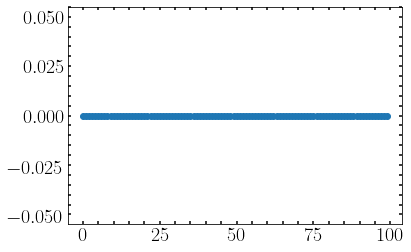

In [90]:
plt.scatter(np.arange(Nboxes), mean_values)